In [1]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset/Pretraining stuff

In [2]:
labels = np.load('/content/drive/My Drive/Colab Notebooks/labels.npy')
audios = np.load('/content/drive/My Drive/Colab Notebooks/audios.npy')

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
import scipy
from scipy import signal, fft
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cv2
import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1, l2


In [4]:
# https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520

def spectrogram(samples, sample_rate=44100, stride_ms = 20.0, 
                          window_ms = 40.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [5]:
import librosa
import librosa.display

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cv2
sr = 44100
# A2S = Audio sequence to spectrogram

# Dont convert to 64x64

def a2s(audio_sequence, sampling_rate=sr,):
    cut_audio = audio_sequence#[audio_sequence!=0]

    spec = spectrogram(cut_audio, sample_rate = sampling_rate, max_freq = 11025)
    return spec

In [7]:
# Uncut audios
import time

start = time.time()
specs = np.apply_along_axis(a2s, 1, audios)

print(time.time() - start)

18.552743911743164


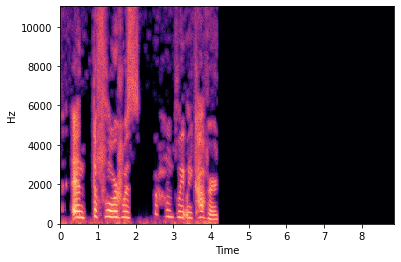

In [8]:
librosa.display.specshow(specs[911], sr=22050, x_axis='time', y_axis='hz')

In [9]:
print(specs.shape)
from keras.callbacks import History

(1272, 442, 382)


In [10]:
mask = np.logical_or(labels=='other', labels=='X')

labels = labels[~mask]
specs = specs[~mask]

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

np.sum(label_binarize(labels, classes=['angry', 'happy', 'sad', 'neutral']), axis=0)

array([284, 224, 186, 524])

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(specs, labels, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=1123)


y_bin = label_binarize(y_train, classes=['angry', 'happy', 'sad', 'neutral',])
y_bin2 = label_binarize(y_test, classes=['angry', 'happy', 'sad', 'neutral',])
y_val_bin = label_binarize(y_val, classes=['angry', 'happy', 'sad', 'neutral',])


In [13]:
print(X_train.shape)

(730, 442, 382)


In [14]:
def plothist(hist):
      plt.plot(hist.history['loss'])
      plt.plot(hist.history['val_loss'])
      plt.title('Model Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper right')
      plt.show()

      plt.plot(hist.history['accuracy'])
      plt.plot(hist.history['val_accuracy'])
      plt.title('Model Accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

In [16]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Reshape((-1, 109, 94, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [17]:
from keras.layers import Reshape, ConvLSTM2D

def create_model2(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Reshape((-1, 109, 94, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [18]:
np.sum(y_bin, axis=0)

array([168, 137, 115, 310])

# .


In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model_2(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Reshape((-1, 109, 94, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist = History()
model = create_model_2(32, 32, 64, 256, 0.2, 0.001, 0.001)
model.fit(X_train, y_bin, epochs=25, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist])

Epoch 1/25
23/23 [==============================] - 15s 457ms/step - loss: 184.4314 - accuracy: 0.2932 - val_loss: 100.0832 - val_accuracy: 0.4317
Epoch 2/25
23/23 [==============================] - 8s 353ms/step - loss: 64.3993 - accuracy: 0.4055 - val_loss: 39.0091 - val_accuracy: 0.4317
Epoch 3/25
23/23 [==============================] - 8s 355ms/step - loss: 29.4652 - accuracy: 0.4301 - val_loss: 23.3730 - val_accuracy: 0.4317
Epoch 4/25
23/23 [==============================] - 8s 349ms/step - loss: 21.1730 - accuracy: 0.4219 - val_loss: 19.5736 - val_accuracy: 0.4317
Epoch 5/25
23/23 [==============================] - 8s 349ms/step - loss: 19.4948 - accuracy: 0.4274 - val_loss: 19.2224 - val_accuracy: 0.4317
Epoch 6/25
23/23 [==============================] - 8s 349ms/step - loss: 19.1538 - accuracy: 0.4219 - val_loss: 18.9790 - val_accuracy: 0.4317
Epoch 7/25
23/23 [==============================] - 8s 348ms/step - loss: 19.0326 - accuracy: 0.4411 - val_loss: 18.9467 - val_accura

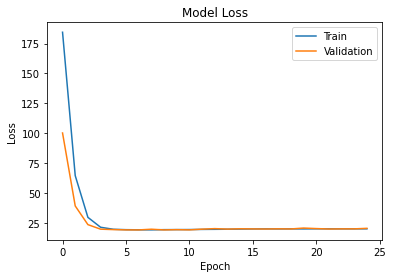

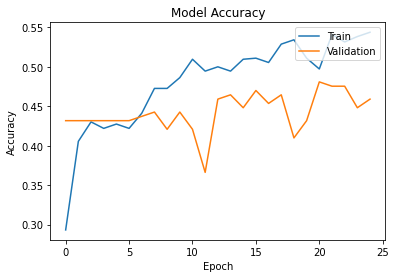

In [ ]:
plothist(hist)

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(classification_report(y_arg, y_pred))

10/10 [==============================] - 1s 88ms/step - loss: 20.2407 - accuracy: 0.5049
Test accuracy: 0.5049180388450623
F1-score: 0.42058643316378314
              precision    recall  f1-score   support

           0       0.54      0.29      0.37        77
           1       0.39      0.19      0.26        47
           2       0.00      0.00      0.00        48
           3       0.51      0.92      0.66       133

    accuracy                           0.50       305
   macro avg       0.36      0.35      0.32       305
weighted avg       0.42      0.50      0.42       305



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Initial Parameters + Learning Rate

In [ ]:
# Start with low values of filters, increase later to make sure we dont overfit.

# Numfilters: 16, 16
# LSTM Units: 32
# Dense Units: 128

# Dropout 0.5
# L1 reg = 0.001
# Learning rate = 0.0001

# Monitor epochs 

Epoch 1/60
23/23 [==============================] - 17s 211ms/step - loss: 65.8173 - accuracy: 0.3534 - val_loss: 39.9031 - val_accuracy: 0.4372
Epoch 2/60
23/23 [==============================] - 3s 149ms/step - loss: 27.1883 - accuracy: 0.4247 - val_loss: 18.3215 - val_accuracy: 0.4372
Epoch 3/60
23/23 [==============================] - 3s 149ms/step - loss: 14.3434 - accuracy: 0.3740 - val_loss: 11.0963 - val_accuracy: 0.1803
Epoch 4/60
23/23 [==============================] - 3s 150ms/step - loss: 9.1718 - accuracy: 0.3603 - val_loss: 7.4237 - val_accuracy: 0.4372
Epoch 5/60
23/23 [==============================] - 3s 150ms/step - loss: 6.4314 - accuracy: 0.3699 - val_loss: 5.4352 - val_accuracy: 0.4372
Epoch 6/60
23/23 [==============================] - 3s 152ms/step - loss: 4.8555 - accuracy: 0.3986 - val_loss: 4.2702 - val_accuracy: 0.4372
Epoch 7/60
23/23 [==============================] - 3s 152ms/step - loss: 3.9131 - accuracy: 0.4151 - val_loss: 3.5449 - val_accuracy: 0.4372

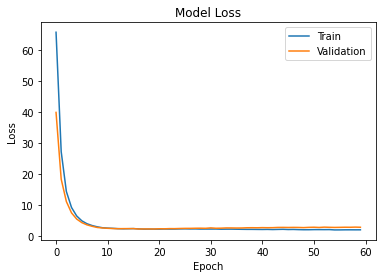

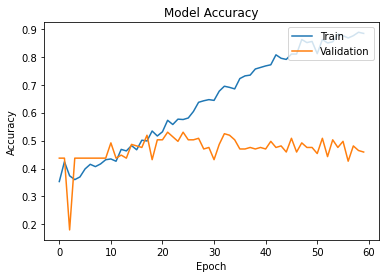

In [ ]:

hist_lr1 = History()
model = create_model(16, 16, 32, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=60, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_lr1])
plothist(hist_lr1)

Epoch 1/60
23/23 [==============================] - 7s 178ms/step - loss: 64.4768 - accuracy: 0.2712 - val_loss: 36.6590 - val_accuracy: 0.1311
Epoch 2/60
23/23 [==============================] - 4s 155ms/step - loss: 28.0474 - accuracy: 0.3247 - val_loss: 19.9668 - val_accuracy: 0.4754
Epoch 3/60
23/23 [==============================] - 4s 153ms/step - loss: 16.2236 - accuracy: 0.3082 - val_loss: 12.9050 - val_accuracy: 0.4153
Epoch 4/60
23/23 [==============================] - 4s 153ms/step - loss: 10.7681 - accuracy: 0.3397 - val_loss: 8.9275 - val_accuracy: 0.4372
Epoch 5/60
23/23 [==============================] - 4s 154ms/step - loss: 8.0169 - accuracy: 0.3849 - val_loss: 7.0329 - val_accuracy: 0.4426
Epoch 6/60
23/23 [==============================] - 4s 154ms/step - loss: 6.5903 - accuracy: 0.4329 - val_loss: 6.1840 - val_accuracy: 0.4372
Epoch 7/60
23/23 [==============================] - 4s 155ms/step - loss: 6.0542 - accuracy: 0.4274 - val_loss: 5.9281 - val_accuracy: 0.4372

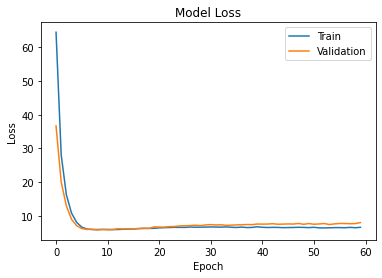

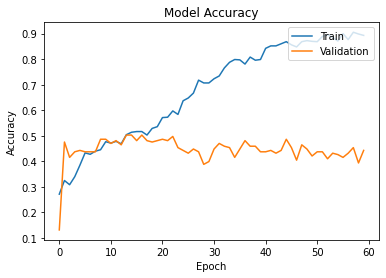

In [ ]:
## LR = 0.001


hist_lr2 = History()
model = create_model(16, 16, 32, 128, 0.5, 0.001, 0.001)
model.fit(X_train, y_bin, epochs=60, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_lr2])
plothist(hist_lr2)

In [ ]:
### This is very overfitting after 25~ epochs. Also highest Validation accuracy is worse. Converges to the highest value faster, but inconsistent in its results
### Retry again with larger regularization to make sure.

Epoch 1/60
23/23 [==============================] - 7s 180ms/step - loss: 267.2739 - accuracy: 0.3082 - val_loss: 107.6947 - val_accuracy: 0.4372
Epoch 2/60
23/23 [==============================] - 4s 153ms/step - loss: 77.7236 - accuracy: 0.3671 - val_loss: 61.9553 - val_accuracy: 0.2568
Epoch 3/60
23/23 [==============================] - 4s 154ms/step - loss: 57.4809 - accuracy: 0.3808 - val_loss: 56.3006 - val_accuracy: 0.4372
Epoch 4/60
23/23 [==============================] - 4s 154ms/step - loss: 54.5076 - accuracy: 0.4055 - val_loss: 52.8798 - val_accuracy: 0.4372
Epoch 5/60
23/23 [==============================] - 4s 154ms/step - loss: 53.6206 - accuracy: 0.4055 - val_loss: 52.9161 - val_accuracy: 0.4372
Epoch 6/60
23/23 [==============================] - 4s 156ms/step - loss: 53.1127 - accuracy: 0.4205 - val_loss: 53.0763 - val_accuracy: 0.4372
Epoch 7/60
23/23 [==============================] - 4s 157ms/step - loss: 52.9978 - accuracy: 0.4356 - val_loss: 53.3114 - val_accurac

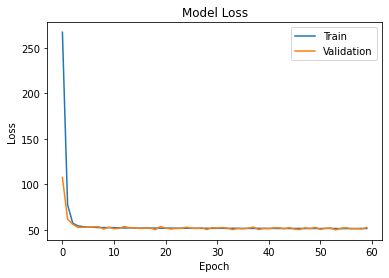

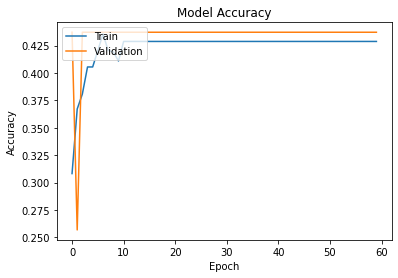

In [ ]:
# LR 0.01, LReg = 0.01

hist_lr3 = History()
model = create_model(16, 16, 32, 128, 0.5, 0.01, 0.001)
model.fit(X_train, y_bin, epochs=60, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_lr3])
plothist(hist_lr3)

Epoch 1/60
23/23 [==============================] - 7s 179ms/step - loss: 88.2057 - accuracy: 0.3342 - val_loss: 84.5044 - val_accuracy: 0.4372
Epoch 2/60
23/23 [==============================] - 4s 154ms/step - loss: 81.2276 - accuracy: 0.4041 - val_loss: 77.5588 - val_accuracy: 0.4372
Epoch 3/60
23/23 [==============================] - 4s 154ms/step - loss: 74.3477 - accuracy: 0.3918 - val_loss: 70.8145 - val_accuracy: 0.4372
Epoch 4/60
23/23 [==============================] - 4s 155ms/step - loss: 67.7343 - accuracy: 0.3753 - val_loss: 64.3301 - val_accuracy: 0.4372
Epoch 5/60
23/23 [==============================] - 4s 155ms/step - loss: 61.4399 - accuracy: 0.4055 - val_loss: 58.2817 - val_accuracy: 0.4372
Epoch 6/60
23/23 [==============================] - 4s 156ms/step - loss: 55.5124 - accuracy: 0.3877 - val_loss: 52.4722 - val_accuracy: 0.4372
Epoch 7/60
23/23 [==============================] - 4s 157ms/step - loss: 49.8975 - accuracy: 0.3932 - val_loss: 47.0495 - val_accuracy:

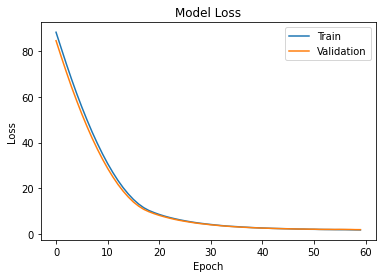

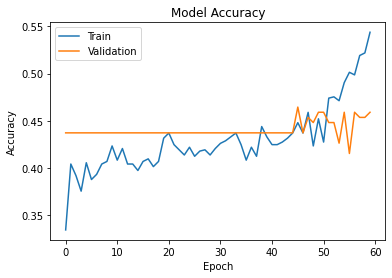

In [ ]:
### Too high regularization, perma stuck in local maximum (probably guessing dominant class)

### Try smaller learning rate, although that might be too small and the same thing might happen

hist_lr4 = History()
model = create_model(16, 16, 32, 128, 0.5, 0.001, 0.00001)
model.fit(X_train, y_bin, epochs=60, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_lr4])
plothist(hist_lr4)

Epoch 1/120
23/23 [==============================] - 7s 178ms/step - loss: 88.3565 - accuracy: 0.3452 - val_loss: 84.7488 - val_accuracy: 0.4372
Epoch 2/120
23/23 [==============================] - 4s 153ms/step - loss: 81.6444 - accuracy: 0.3822 - val_loss: 78.1682 - val_accuracy: 0.4372
Epoch 3/120
23/23 [==============================] - 4s 154ms/step - loss: 75.0985 - accuracy: 0.3890 - val_loss: 71.7042 - val_accuracy: 0.4372
Epoch 4/120
23/23 [==============================] - 4s 154ms/step - loss: 68.7526 - accuracy: 0.3945 - val_loss: 65.5289 - val_accuracy: 0.4372
Epoch 5/120
23/23 [==============================] - 4s 155ms/step - loss: 62.7478 - accuracy: 0.3959 - val_loss: 59.6610 - val_accuracy: 0.4372
Epoch 6/120
23/23 [==============================] - 4s 155ms/step - loss: 56.9916 - accuracy: 0.4192 - val_loss: 54.0577 - val_accuracy: 0.4372
Epoch 7/120
23/23 [==============================] - 4s 155ms/step - loss: 51.5552 - accuracy: 0.4164 - val_loss: 48.7884 - val_ac

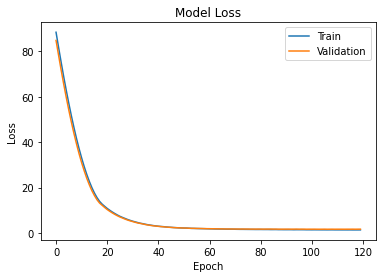

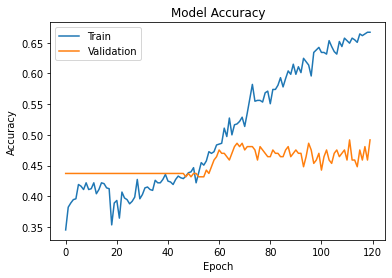

In [ ]:
### Val loss still decreasing and accuracy slowly getting better. Try more epochs.

hist_lr4 = History()
model = create_model(16, 16, 32, 128, 0.5, 0.001, 0.00001)
model.fit(X_train, y_bin, epochs=120, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_lr4])
plothist(hist_lr4)

In [ ]:
## Doesnt reach over 50%. Last effort try 0.0005 since 0.001 and 0.0001 performed better.



Epoch 1/50
23/23 [==============================] - 7s 184ms/step - loss: 46.6329 - accuracy: 0.3041 - val_loss: 23.0618 - val_accuracy: 0.4372
Epoch 2/50
23/23 [==============================] - 4s 157ms/step - loss: 16.2274 - accuracy: 0.3452 - val_loss: 10.5842 - val_accuracy: 0.2514
Epoch 3/50
23/23 [==============================] - 4s 157ms/step - loss: 8.3079 - accuracy: 0.3479 - val_loss: 6.4070 - val_accuracy: 0.4372
Epoch 4/50
23/23 [==============================] - 4s 157ms/step - loss: 5.9472 - accuracy: 0.3904 - val_loss: 5.0777 - val_accuracy: 0.4372
Epoch 5/50
23/23 [==============================] - 4s 158ms/step - loss: 4.5004 - accuracy: 0.4178 - val_loss: 4.0691 - val_accuracy: 0.4372
Epoch 6/50
23/23 [==============================] - 4s 158ms/step - loss: 3.8571 - accuracy: 0.4288 - val_loss: 3.7027 - val_accuracy: 0.4372
Epoch 7/50
23/23 [==============================] - 4s 157ms/step - loss: 3.6837 - accuracy: 0.4288 - val_loss: 3.6258 - val_accuracy: 0.4372
Ep

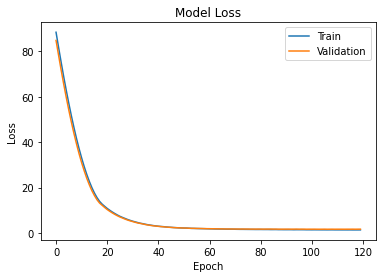

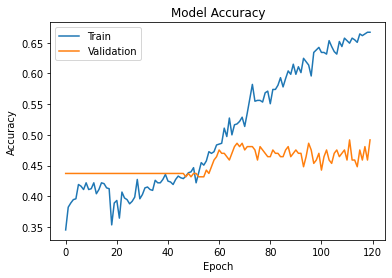

In [ ]:

hist_lr5 = History()
model = create_model(16, 16, 32, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_lr5])
plothist(hist_lr4)

# Pooling


In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Reshape((-1, 109, 94, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
hist_mp2 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_mp2])
plothist(hist_lr4)

Epoch 1/50
23/23 [==============================] - 24s 459ms/step - loss: 78.1626 - accuracy: 0.2795 - val_loss: 44.4853 - val_accuracy: 0.4426
Epoch 2/50
23/23 [==============================] - 8s 355ms/step - loss: 29.5039 - accuracy: 0.3603 - val_loss: 17.7139 - val_accuracy: 0.4426
Epoch 3/50
23/23 [==============================] - 8s 357ms/step - loss: 12.9595 - accuracy: 0.4260 - val_loss: 9.4200 - val_accuracy: 0.4426
Epoch 4/50
23/23 [==============================] - 8s 363ms/step - loss: 8.0283 - accuracy: 0.4301 - val_loss: 7.0279 - val_accuracy: 0.4426
Epoch 5/50
23/23 [==============================] - 8s 363ms/step - loss: 6.6489 - accuracy: 0.4315 - val_loss: 6.2804 - val_accuracy: 0.4426
Epoch 6/50
23/23 [==============================] - 8s 368ms/step - loss: 6.1783 - accuracy: 0.4384 - val_loss: 6.0553 - val_accuracy: 0.4426
Epoch 7/50
23/23 [==============================] - 8s 368ms/step - loss: 6.0592 - accuracy: 0.4356 - val_loss: 5.9851 - val_accuracy: 0.4809


NameError: ignored

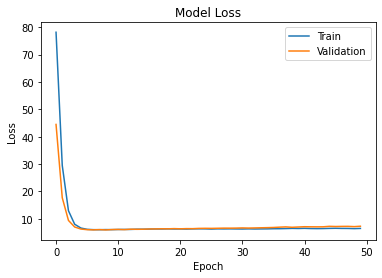

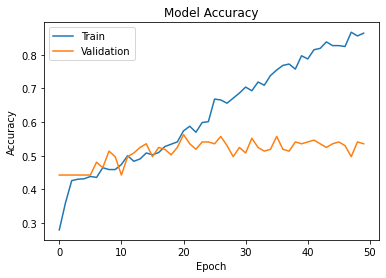

In [ ]:
plothist(hist_mp2)

Epoch 1/35
23/23 [==============================] - 12s 397ms/step - loss: 76.0687 - accuracy: 0.3055 - val_loss: 38.8675 - val_accuracy: 0.4426
Epoch 2/35
23/23 [==============================] - 9s 372ms/step - loss: 24.5382 - accuracy: 0.4178 - val_loss: 14.1189 - val_accuracy: 0.4426
Epoch 3/35
23/23 [==============================] - 9s 374ms/step - loss: 10.4389 - accuracy: 0.4301 - val_loss: 7.9154 - val_accuracy: 0.4426
Epoch 4/35
23/23 [==============================] - 8s 370ms/step - loss: 7.1023 - accuracy: 0.4329 - val_loss: 6.5093 - val_accuracy: 0.4426
Epoch 5/35
23/23 [==============================] - 8s 367ms/step - loss: 6.4154 - accuracy: 0.4315 - val_loss: 6.3500 - val_accuracy: 0.4426
Epoch 6/35
23/23 [==============================] - 8s 363ms/step - loss: 6.3056 - accuracy: 0.4260 - val_loss: 6.2108 - val_accuracy: 0.4426
Epoch 7/35
23/23 [==============================] - 8s 362ms/step - loss: 6.3200 - accuracy: 0.4342 - val_loss: 6.2429 - val_accuracy: 0.4426


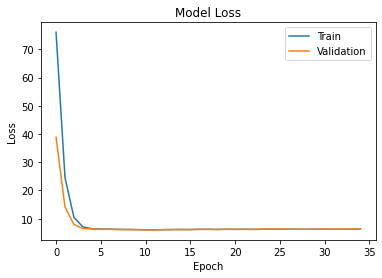

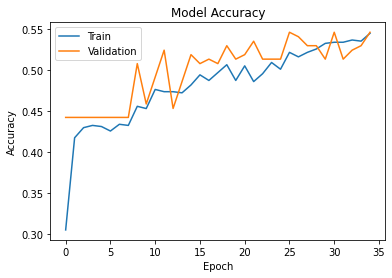

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model2(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Reshape((-1, 109, 94, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_ap2 = History()
model = create_model2(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=35, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_ap2])
plothist(hist_ap2)

Epoch 1/35
23/23 [==============================] - 7s 182ms/step - loss: 32.2888 - accuracy: 0.3247 - val_loss: 17.3576 - val_accuracy: 0.4426
Epoch 2/35
23/23 [==============================] - 3s 122ms/step - loss: 12.6706 - accuracy: 0.3658 - val_loss: 8.7566 - val_accuracy: 0.4426
Epoch 3/35
23/23 [==============================] - 3s 122ms/step - loss: 6.8829 - accuracy: 0.4096 - val_loss: 5.3284 - val_accuracy: 0.4426
Epoch 4/35
23/23 [==============================] - 3s 122ms/step - loss: 4.5693 - accuracy: 0.4151 - val_loss: 3.8696 - val_accuracy: 0.4426
Epoch 5/35
23/23 [==============================] - 3s 123ms/step - loss: 3.5166 - accuracy: 0.3986 - val_loss: 3.1974 - val_accuracy: 0.4426
Epoch 6/35
23/23 [==============================] - 3s 123ms/step - loss: 2.9905 - accuracy: 0.4356 - val_loss: 2.7954 - val_accuracy: 0.4426
Epoch 7/35
23/23 [==============================] - 3s 123ms/step - loss: 2.7415 - accuracy: 0.4301 - val_loss: 2.6420 - val_accuracy: 0.4426
Epo

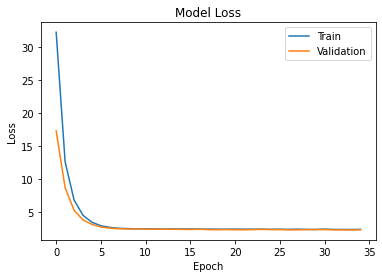

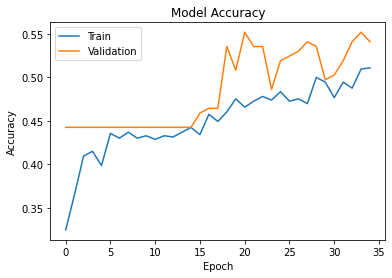

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 48, 41, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_mp3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=35, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_mp3])
plothist(hist_mp3)

Epoch 1/45
23/23 [==============================] - 6s 123ms/step - loss: 21.5526 - accuracy: 0.3808 - val_loss: 12.1202 - val_accuracy: 0.4426
Epoch 2/45
23/23 [==============================] - 2s 80ms/step - loss: 8.9965 - accuracy: 0.4260 - val_loss: 6.2628 - val_accuracy: 0.4426
Epoch 3/45
23/23 [==============================] - 2s 81ms/step - loss: 4.9784 - accuracy: 0.4288 - val_loss: 3.8756 - val_accuracy: 0.4426
Epoch 4/45
23/23 [==============================] - 2s 80ms/step - loss: 3.3670 - accuracy: 0.4315 - val_loss: 2.8648 - val_accuracy: 0.4426
Epoch 5/45
23/23 [==============================] - 2s 80ms/step - loss: 2.6442 - accuracy: 0.4329 - val_loss: 2.3808 - val_accuracy: 0.4426
Epoch 6/45
23/23 [==============================] - 2s 80ms/step - loss: 2.2798 - accuracy: 0.4301 - val_loss: 2.1325 - val_accuracy: 0.4426
Epoch 7/45
23/23 [==============================] - 2s 82ms/step - loss: 2.0774 - accuracy: 0.4356 - val_loss: 1.9853 - val_accuracy: 0.4426
Epoch 8/45

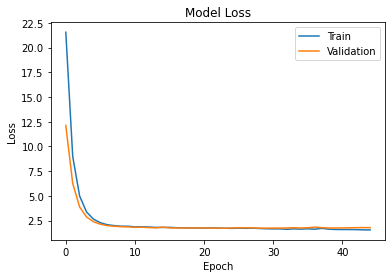

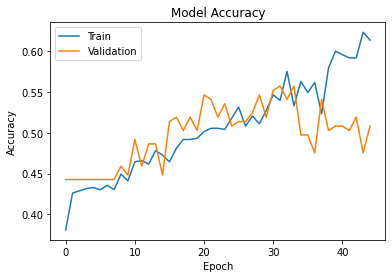

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Reshape((-1, 27, 23, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_mp4 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=45, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_mp4])
plothist(hist_mp4)

Epoch 1/50
23/23 [==============================] - 5s 95ms/step - loss: 15.2075 - accuracy: 0.3849 - val_loss: 9.4300 - val_accuracy: 0.4426
Epoch 2/50
23/23 [==============================] - 2s 67ms/step - loss: 6.6921 - accuracy: 0.4301 - val_loss: 4.8039 - val_accuracy: 0.4426
Epoch 3/50
23/23 [==============================] - 2s 66ms/step - loss: 3.9389 - accuracy: 0.4342 - val_loss: 3.1703 - val_accuracy: 0.4426
Epoch 4/50
23/23 [==============================] - 2s 67ms/step - loss: 2.8304 - accuracy: 0.4356 - val_loss: 2.4664 - val_accuracy: 0.4426
Epoch 5/50
23/23 [==============================] - 2s 68ms/step - loss: 2.2979 - accuracy: 0.4370 - val_loss: 2.0731 - val_accuracy: 0.4426
Epoch 6/50
23/23 [==============================] - 2s 69ms/step - loss: 2.0429 - accuracy: 0.4219 - val_loss: 1.8979 - val_accuracy: 0.4426
Epoch 7/50
23/23 [==============================] - 2s 68ms/step - loss: 1.8620 - accuracy: 0.4274 - val_loss: 1.7565 - val_accuracy: 0.4536
Epoch 8/50
2

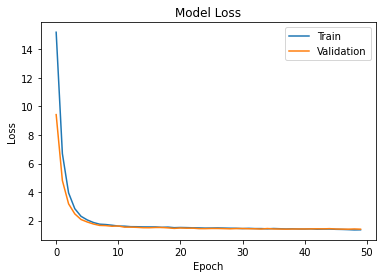

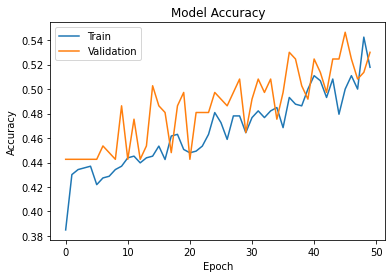

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Reshape((-1, 17, 14, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_mp5 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_mp5])
plothist(hist_mp5)

Epoch 1/40
23/23 [==============================] - 6s 147ms/step - loss: 34.3627 - accuracy: 0.2945 - val_loss: 19.6700 - val_accuracy: 0.2350
Epoch 2/40
23/23 [==============================] - 3s 119ms/step - loss: 14.4318 - accuracy: 0.3548 - val_loss: 9.9644 - val_accuracy: 0.4426
Epoch 3/40
23/23 [==============================] - 3s 120ms/step - loss: 7.6885 - accuracy: 0.3767 - val_loss: 5.7556 - val_accuracy: 0.4426
Epoch 4/40
23/23 [==============================] - 3s 120ms/step - loss: 4.8106 - accuracy: 0.4014 - val_loss: 3.9689 - val_accuracy: 0.4426
Epoch 5/40
23/23 [==============================] - 3s 121ms/step - loss: 3.5214 - accuracy: 0.4247 - val_loss: 3.0784 - val_accuracy: 0.4426
Epoch 6/40
23/23 [==============================] - 3s 123ms/step - loss: 2.9237 - accuracy: 0.4233 - val_loss: 2.6901 - val_accuracy: 0.4426
Epoch 7/40
23/23 [==============================] - 3s 123ms/step - loss: 2.6368 - accuracy: 0.4370 - val_loss: 2.5359 - val_accuracy: 0.4426
Epo

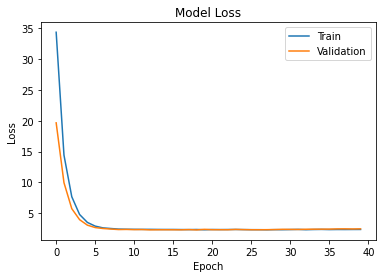

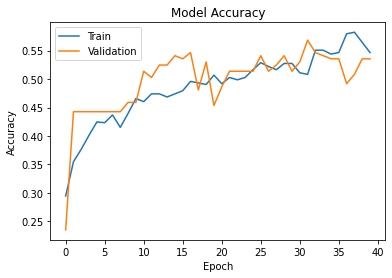

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 48, 41, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_mp3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_mp3])
plothist(hist_mp3)

Epoch 1/45
23/23 [==============================] - 5s 104ms/step - loss: 20.4168 - accuracy: 0.3822 - val_loss: 10.5485 - val_accuracy: 0.4426
Epoch 2/45
23/23 [==============================] - 2s 77ms/step - loss: 7.7544 - accuracy: 0.4370 - val_loss: 5.3465 - val_accuracy: 0.4426
Epoch 3/45
23/23 [==============================] - 2s 77ms/step - loss: 4.3133 - accuracy: 0.4082 - val_loss: 3.4460 - val_accuracy: 0.4426
Epoch 4/45
23/23 [==============================] - 2s 77ms/step - loss: 3.0304 - accuracy: 0.4342 - val_loss: 2.6306 - val_accuracy: 0.4426
Epoch 5/45
23/23 [==============================] - 2s 77ms/step - loss: 2.4411 - accuracy: 0.4247 - val_loss: 2.2216 - val_accuracy: 0.4426
Epoch 6/45
23/23 [==============================] - 2s 78ms/step - loss: 2.1448 - accuracy: 0.4342 - val_loss: 2.0179 - val_accuracy: 0.4536
Epoch 7/45
23/23 [==============================] - 2s 78ms/step - loss: 2.0005 - accuracy: 0.4425 - val_loss: 1.9271 - val_accuracy: 0.4590
Epoch 8/45

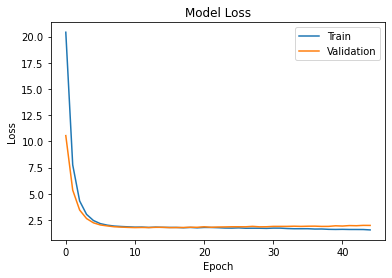

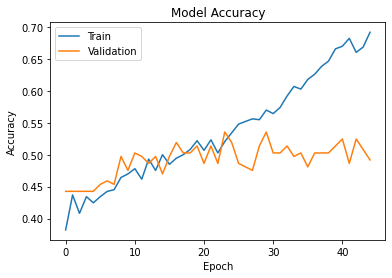

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(4, 4)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(4, 4)))
    model.add(Reshape((-1, 27, 23, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_mp4 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=45, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_mp4])
plothist(hist_mp4)

Epoch 1/50
23/23 [==============================] - 5s 93ms/step - loss: 15.7265 - accuracy: 0.3849 - val_loss: 10.1135 - val_accuracy: 0.4426
Epoch 2/50
23/23 [==============================] - 1s 65ms/step - loss: 7.3665 - accuracy: 0.4315 - val_loss: 5.3492 - val_accuracy: 0.4426
Epoch 3/50
23/23 [==============================] - 1s 64ms/step - loss: 4.3685 - accuracy: 0.4301 - val_loss: 3.5163 - val_accuracy: 0.4426
Epoch 4/50
23/23 [==============================] - 1s 63ms/step - loss: 3.1038 - accuracy: 0.4301 - val_loss: 2.6959 - val_accuracy: 0.4590
Epoch 5/50
23/23 [==============================] - 1s 64ms/step - loss: 2.4919 - accuracy: 0.4342 - val_loss: 2.2214 - val_accuracy: 0.4645
Epoch 6/50
23/23 [==============================] - 1s 64ms/step - loss: 2.1333 - accuracy: 0.4397 - val_loss: 1.9865 - val_accuracy: 0.4590
Epoch 7/50
23/23 [==============================] - 1s 64ms/step - loss: 1.9023 - accuracy: 0.4521 - val_loss: 1.7906 - val_accuracy: 0.5027
Epoch 8/50


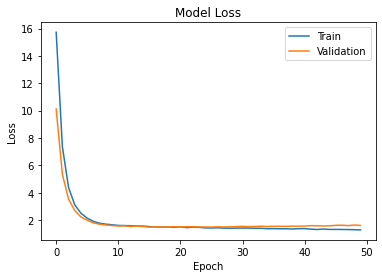

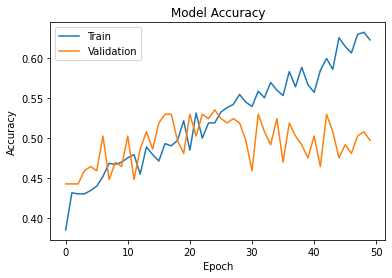

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(5, 5)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(5, 5)))
    model.add(Reshape((-1, 17, 14, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_mp5 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_mp5])
plothist(hist_mp5)

# Dropout

Epoch 1/30
23/23 [==============================] - 21s 753ms/step - loss: 105.3025 - accuracy: 0.3425 - val_loss: 51.0417 - val_accuracy: 0.4098
Epoch 2/30
23/23 [==============================] - 13s 588ms/step - loss: 34.5186 - accuracy: 0.3890 - val_loss: 21.5204 - val_accuracy: 0.4098
Epoch 3/30
23/23 [==============================] - 14s 591ms/step - loss: 15.6361 - accuracy: 0.3904 - val_loss: 11.1643 - val_accuracy: 0.4098
Epoch 4/30
23/23 [==============================] - 14s 596ms/step - loss: 8.9556 - accuracy: 0.4041 - val_loss: 7.2145 - val_accuracy: 0.4098
Epoch 5/30
23/23 [==============================] - 14s 598ms/step - loss: 6.2395 - accuracy: 0.3849 - val_loss: 5.6064 - val_accuracy: 0.4098
Epoch 6/30
23/23 [==============================] - 14s 602ms/step - loss: 5.0521 - accuracy: 0.4274 - val_loss: 4.6441 - val_accuracy: 0.4098
Epoch 7/30
23/23 [==============================] - 14s 606ms/step - loss: 4.5223 - accuracy: 0.4123 - val_loss: 4.4535 - val_accuracy:

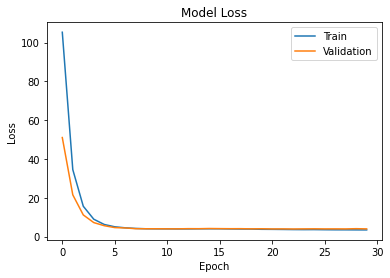

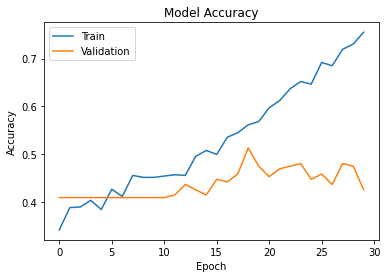

In [ ]:
hist_dr1 = History()
model = create_model2(32, 64, 128, 128, 0.3, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=30, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_dr1])
plothist(hist_dr1)

Epoch 1/30
23/23 [==============================] - 18s 607ms/step - loss: 106.7463 - accuracy: 0.3411 - val_loss: 53.4316 - val_accuracy: 0.4372
Epoch 2/30
23/23 [==============================] - 13s 585ms/step - loss: 37.1573 - accuracy: 0.3959 - val_loss: 24.0757 - val_accuracy: 0.2350
Epoch 3/30
23/23 [==============================] - 13s 589ms/step - loss: 18.0373 - accuracy: 0.3630 - val_loss: 12.9408 - val_accuracy: 0.2186
Epoch 4/30
23/23 [==============================] - 14s 595ms/step - loss: 10.8232 - accuracy: 0.3534 - val_loss: 8.8606 - val_accuracy: 0.4372
Epoch 5/30
23/23 [==============================] - 14s 596ms/step - loss: 7.6572 - accuracy: 0.3671 - val_loss: 6.8281 - val_accuracy: 0.4372
Epoch 6/30
23/23 [==============================] - 14s 601ms/step - loss: 6.4423 - accuracy: 0.3370 - val_loss: 5.9160 - val_accuracy: 0.4372
Epoch 7/30
23/23 [==============================] - 14s 607ms/step - loss: 5.4798 - accuracy: 0.3616 - val_loss: 4.9287 - val_accuracy

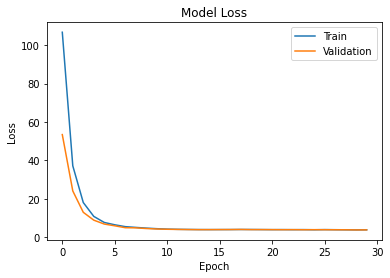

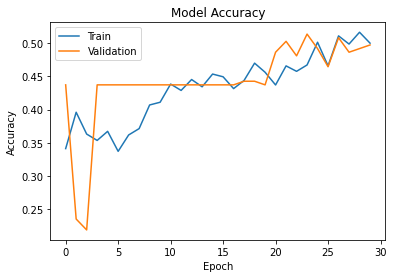

In [ ]:
hist_dr1 = History()
model = create_model2(32, 64, 128, 128, 0.8, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=30, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_dr1])
plothist(hist_dr1)

Epoch 1/30
23/23 [==============================] - 19s 620ms/step - loss: 102.6342 - accuracy: 0.3123 - val_loss: 47.6707 - val_accuracy: 0.4372
Epoch 2/30
23/23 [==============================] - 14s 594ms/step - loss: 31.9349 - accuracy: 0.3575 - val_loss: 19.5074 - val_accuracy: 0.4372
Epoch 3/30
23/23 [==============================] - 14s 600ms/step - loss: 14.4297 - accuracy: 0.3068 - val_loss: 10.3897 - val_accuracy: 0.4372
Epoch 4/30
23/23 [==============================] - 14s 602ms/step - loss: 8.3989 - accuracy: 0.3534 - val_loss: 6.8365 - val_accuracy: 0.2186
Epoch 5/30
23/23 [==============================] - 14s 605ms/step - loss: 6.2628 - accuracy: 0.3753 - val_loss: 5.5278 - val_accuracy: 0.4372
Epoch 6/30
23/23 [==============================] - 14s 612ms/step - loss: 5.1342 - accuracy: 0.4068 - val_loss: 4.6986 - val_accuracy: 0.4372
Epoch 7/30
23/23 [==============================] - 14s 624ms/step - loss: 4.4534 - accuracy: 0.4411 - val_loss: 4.2349 - val_accuracy:

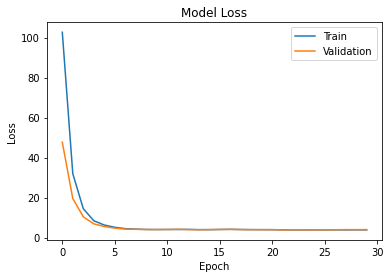

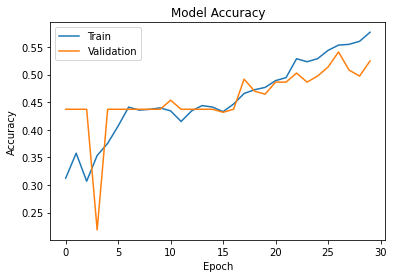

In [ ]:
hist_dr1 = History()
model = create_model2(32, 64, 128, 128, 0.65, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=30, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_dr1])
plothist(hist_dr1)

# Num Filters (feature extraction block)

Epoch 1/50
23/23 [==============================] - 13s 390ms/step - loss: 89.8679 - accuracy: 0.2986 - val_loss: 50.0301 - val_accuracy: 0.4372
Epoch 2/50
23/23 [==============================] - 7s 302ms/step - loss: 35.9053 - accuracy: 0.3986 - val_loss: 24.6347 - val_accuracy: 0.4372
Epoch 3/50
23/23 [==============================] - 7s 292ms/step - loss: 19.0065 - accuracy: 0.3836 - val_loss: 14.0307 - val_accuracy: 0.4372
Epoch 4/50
23/23 [==============================] - 7s 294ms/step - loss: 11.3823 - accuracy: 0.3603 - val_loss: 8.9950 - val_accuracy: 0.4372
Epoch 5/50
23/23 [==============================] - 7s 294ms/step - loss: 7.6392 - accuracy: 0.3753 - val_loss: 6.3002 - val_accuracy: 0.4372
Epoch 6/50
23/23 [==============================] - 7s 296ms/step - loss: 5.5796 - accuracy: 0.3959 - val_loss: 4.8628 - val_accuracy: 0.4372
Epoch 7/50
23/23 [==============================] - 7s 296ms/step - loss: 4.3915 - accuracy: 0.4123 - val_loss: 3.9532 - val_accuracy: 0.437

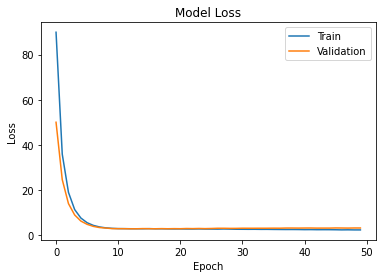

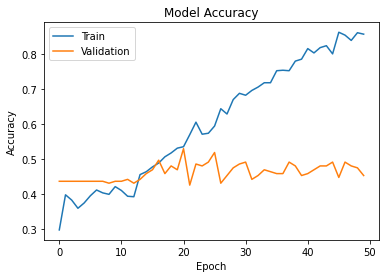

In [ ]:
### We already tested 16, 16, 32, lets see how we perform with more filters for a more complex model


###
hist_nf1 = History()
model = create_model(32, 32, 64, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

Epoch 1/40
23/23 [==============================] - 17s 543ms/step - loss: 88.0317 - accuracy: 0.3438 - val_loss: 48.6506 - val_accuracy: 0.4372
Epoch 2/40
23/23 [==============================] - 10s 417ms/step - loss: 35.2192 - accuracy: 0.3699 - val_loss: 24.5082 - val_accuracy: 0.4372
Epoch 3/40
23/23 [==============================] - 10s 419ms/step - loss: 19.1172 - accuracy: 0.3712 - val_loss: 14.5444 - val_accuracy: 0.1311
Epoch 4/40
23/23 [==============================] - 10s 421ms/step - loss: 12.1755 - accuracy: 0.3342 - val_loss: 9.8324 - val_accuracy: 0.4372
Epoch 5/40
23/23 [==============================] - 10s 422ms/step - loss: 8.5360 - accuracy: 0.3671 - val_loss: 7.1584 - val_accuracy: 0.4372
Epoch 6/40
23/23 [==============================] - 10s 421ms/step - loss: 6.4052 - accuracy: 0.3699 - val_loss: 5.6049 - val_accuracy: 0.4372
Epoch 7/40
23/23 [==============================] - 10s 423ms/step - loss: 5.0853 - accuracy: 0.4110 - val_loss: 4.5834 - val_accuracy:

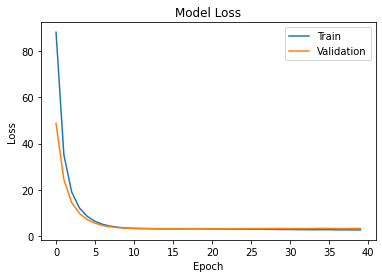

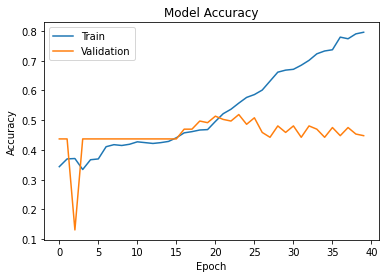

In [ ]:
### 64, 64, 64

hist_nf2 = History()
model = create_model(64, 64, 64, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf2])
plothist(hist_nf2)

Epoch 1/50
23/23 [==============================] - 29s 870ms/step - loss: 102.5491 - accuracy: 0.3329 - val_loss: 46.1380 - val_accuracy: 0.4699
Epoch 2/50
23/23 [==============================] - 15s 667ms/step - loss: 29.3306 - accuracy: 0.3534 - val_loss: 16.7132 - val_accuracy: 0.4699
Epoch 3/50
23/23 [==============================] - 15s 666ms/step - loss: 12.0467 - accuracy: 0.3164 - val_loss: 8.4759 - val_accuracy: 0.4699
Epoch 4/50
23/23 [==============================] - 15s 671ms/step - loss: 7.2042 - accuracy: 0.3562 - val_loss: 6.0262 - val_accuracy: 0.4699
Epoch 5/50
23/23 [==============================] - 15s 675ms/step - loss: 5.5274 - accuracy: 0.4000 - val_loss: 5.0629 - val_accuracy: 0.4699
Epoch 6/50
23/23 [==============================] - 16s 680ms/step - loss: 4.9708 - accuracy: 0.3685 - val_loss: 4.7503 - val_accuracy: 0.4699
Epoch 7/50
23/23 [==============================] - 16s 685ms/step - loss: 4.6990 - accuracy: 0.4151 - val_loss: 4.4711 - val_accuracy: 

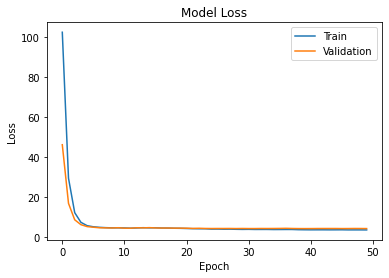

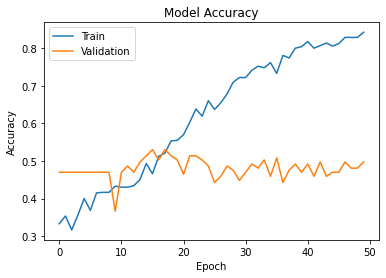

In [ ]:
### 64, 64, 128

hist_nf3 = History()
model = create_model(64, 64, 128, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf3])
plothist(hist_nf3)

Epoch 1/50
23/23 [==============================] - 21s 716ms/step - loss: 105.7672 - accuracy: 0.3055 - val_loss: 50.7674 - val_accuracy: 0.4699
Epoch 2/50
23/23 [==============================] - 14s 631ms/step - loss: 34.4489 - accuracy: 0.3411 - val_loss: 21.2414 - val_accuracy: 0.4699
Epoch 3/50
23/23 [==============================] - 14s 622ms/step - loss: 15.5363 - accuracy: 0.3589 - val_loss: 11.0136 - val_accuracy: 0.1530
Epoch 4/50
23/23 [==============================] - 14s 615ms/step - loss: 8.7826 - accuracy: 0.3507 - val_loss: 6.9444 - val_accuracy: 0.4699
Epoch 5/50
23/23 [==============================] - 14s 613ms/step - loss: 6.0878 - accuracy: 0.3945 - val_loss: 5.2269 - val_accuracy: 0.4699
Epoch 6/50
23/23 [==============================] - 14s 627ms/step - loss: 4.8622 - accuracy: 0.4110 - val_loss: 4.4380 - val_accuracy: 0.4699
Epoch 7/50
23/23 [==============================] - 14s 633ms/step - loss: 4.3548 - accuracy: 0.4164 - val_loss: 4.1716 - val_accuracy:

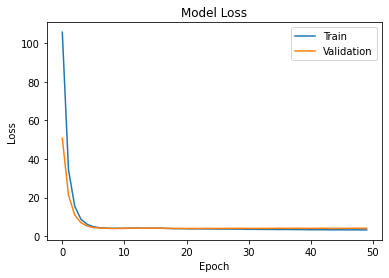

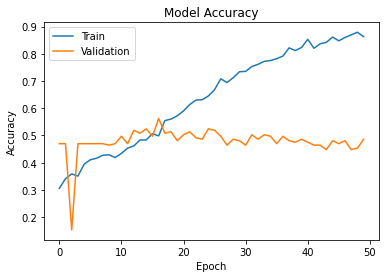

In [ ]:
### 32, 64, 128

hist_nf4 = History()
model = create_model(32, 64, 128, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf4])
plothist(hist_nf4)

In [ ]:
### 32, 64, 256
### Also 50 epochs is way too much 
### 256 LSTM takes too much computational power so skip that value

hist_nf5 = History()
model = create_model(32, 64, 256, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=30, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf5])
plothist(hist_nf5)

Epoch 1/30


ResourceExhaustedError: ignored

Epoch 1/30
23/23 [==============================] - 32s 994ms/step - loss: 98.7846 - accuracy: 0.3123 - val_loss: 44.4138 - val_accuracy: 0.4044
Epoch 2/30
23/23 [==============================] - 18s 803ms/step - loss: 29.4925 - accuracy: 0.3671 - val_loss: 18.1501 - val_accuracy: 0.2623
Epoch 3/30
23/23 [==============================] - 19s 810ms/step - loss: 13.7111 - accuracy: 0.3507 - val_loss: 10.1910 - val_accuracy: 0.4044
Epoch 4/30
23/23 [==============================] - 19s 815ms/step - loss: 8.5869 - accuracy: 0.4000 - val_loss: 7.1885 - val_accuracy: 0.4044
Epoch 5/30
23/23 [==============================] - 19s 822ms/step - loss: 6.4896 - accuracy: 0.4288 - val_loss: 5.9742 - val_accuracy: 0.4044
Epoch 6/30
23/23 [==============================] - 19s 830ms/step - loss: 5.6525 - accuracy: 0.4274 - val_loss: 5.4345 - val_accuracy: 0.4044
Epoch 7/30
23/23 [==============================] - 19s 837ms/step - loss: 5.2309 - accuracy: 0.4342 - val_loss: 5.1673 - val_accuracy: 

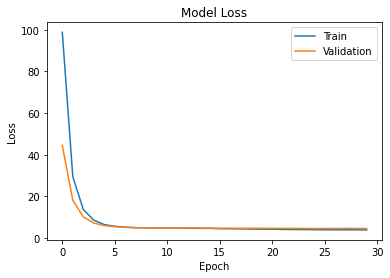

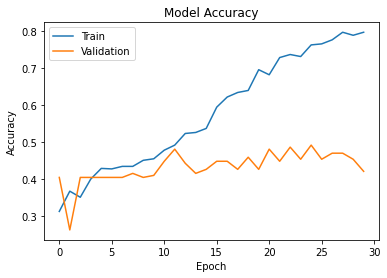

In [ ]:
### 64, 128, 128

hist_nf5 = History()
model = create_model(64, 128, 128, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=30, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf5])
plothist(hist_nf5)

Epoch 1/50
23/23 [==============================] - 14s 373ms/step - loss: 76.5635 - accuracy: 0.3192 - val_loss: 33.2843 - val_accuracy: 0.4044
Epoch 2/50
23/23 [==============================] - 6s 278ms/step - loss: 22.0009 - accuracy: 0.3575 - val_loss: 13.7902 - val_accuracy: 0.4044
Epoch 3/50
23/23 [==============================] - 6s 279ms/step - loss: 10.2921 - accuracy: 0.4014 - val_loss: 7.5149 - val_accuracy: 0.4044
Epoch 4/50
23/23 [==============================] - 6s 279ms/step - loss: 6.1691 - accuracy: 0.4205 - val_loss: 5.0554 - val_accuracy: 0.4044
Epoch 5/50
23/23 [==============================] - 6s 278ms/step - loss: 4.4068 - accuracy: 0.4342 - val_loss: 3.9047 - val_accuracy: 0.4044
Epoch 6/50
23/23 [==============================] - 6s 276ms/step - loss: 3.5870 - accuracy: 0.4356 - val_loss: 3.3610 - val_accuracy: 0.4044
Epoch 7/50
23/23 [==============================] - 6s 276ms/step - loss: 3.2486 - accuracy: 0.4397 - val_loss: 3.1233 - val_accuracy: 0.4098


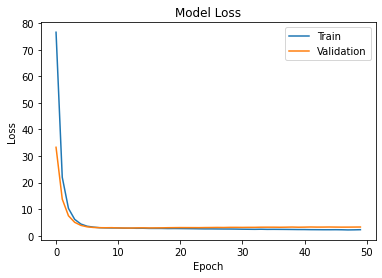

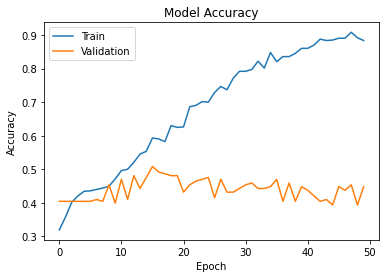

In [ ]:
# 16, 32, 64

hist_nf7 = History()
model = create_model(16, 32, 64, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf7])
plothist(hist_nf7)

Epoch 1/50
23/23 [==============================] - 12s 374ms/step - loss: 80.9915 - accuracy: 0.3000 - val_loss: 38.4272 - val_accuracy: 0.4044
Epoch 2/50
23/23 [==============================] - 7s 318ms/step - loss: 25.8449 - accuracy: 0.3452 - val_loss: 16.4716 - val_accuracy: 0.4044
Epoch 3/50
23/23 [==============================] - 7s 321ms/step - loss: 12.2647 - accuracy: 0.3603 - val_loss: 8.8513 - val_accuracy: 0.4044
Epoch 4/50
23/23 [==============================] - 7s 324ms/step - loss: 7.2814 - accuracy: 0.3685 - val_loss: 6.0375 - val_accuracy: 0.4044
Epoch 5/50
23/23 [==============================] - 7s 324ms/step - loss: 5.3427 - accuracy: 0.3753 - val_loss: 4.5642 - val_accuracy: 0.4044
Epoch 6/50
23/23 [==============================] - 7s 321ms/step - loss: 4.1365 - accuracy: 0.4260 - val_loss: 3.7929 - val_accuracy: 0.4044
Epoch 7/50
23/23 [==============================] - 7s 320ms/step - loss: 3.5474 - accuracy: 0.4219 - val_loss: 3.3320 - val_accuracy: 0.4044


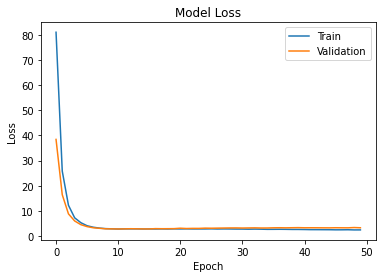

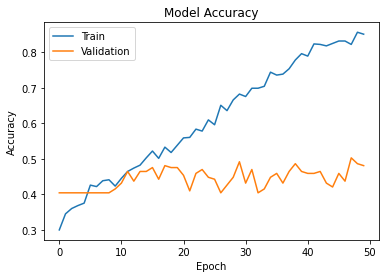

In [ ]:
# 16 64 64 

hist_nf8 = History()
model = create_model(16, 64, 64, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf8])
plothist(hist_nf8)

Epoch 1/50
23/23 [==============================] - 10s 272ms/step - loss: 65.9903 - accuracy: 0.3534 - val_loss: 40.5758 - val_accuracy: 0.3880
Epoch 2/50
23/23 [==============================] - 5s 197ms/step - loss: 27.3469 - accuracy: 0.3767 - val_loss: 17.9473 - val_accuracy: 0.4044
Epoch 3/50
23/23 [==============================] - 5s 197ms/step - loss: 13.5775 - accuracy: 0.4205 - val_loss: 9.9975 - val_accuracy: 0.4044
Epoch 4/50
23/23 [==============================] - 5s 197ms/step - loss: 8.0184 - accuracy: 0.4014 - val_loss: 6.2456 - val_accuracy: 0.4044
Epoch 5/50
23/23 [==============================] - 5s 198ms/step - loss: 5.2389 - accuracy: 0.4178 - val_loss: 4.3260 - val_accuracy: 0.4044
Epoch 6/50
23/23 [==============================] - 5s 199ms/step - loss: 3.7657 - accuracy: 0.4384 - val_loss: 3.3298 - val_accuracy: 0.4208
Epoch 7/50
23/23 [==============================] - 5s 200ms/step - loss: 3.0557 - accuracy: 0.4466 - val_loss: 2.8400 - val_accuracy: 0.4153


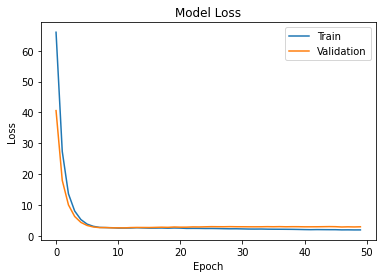

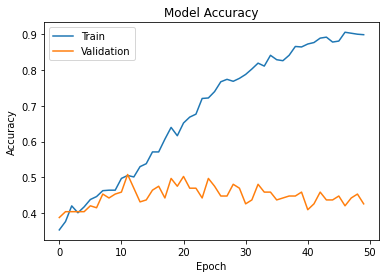

In [ ]:
hist_nf1 = History()
model = create_model(32, 32, 32, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

Epoch 1/30
23/23 [==============================] - 13s 407ms/step - loss: 85.5084 - accuracy: 0.3274 - val_loss: 45.5224 - val_accuracy: 0.4044
Epoch 2/30
23/23 [==============================] - 8s 339ms/step - loss: 31.6252 - accuracy: 0.3877 - val_loss: 20.7899 - val_accuracy: 0.4044
Epoch 3/30
23/23 [==============================] - 8s 341ms/step - loss: 15.5215 - accuracy: 0.3945 - val_loss: 11.0763 - val_accuracy: 0.4044
Epoch 4/30
23/23 [==============================] - 8s 342ms/step - loss: 8.8063 - accuracy: 0.4014 - val_loss: 6.8614 - val_accuracy: 0.4044
Epoch 5/30
23/23 [==============================] - 8s 343ms/step - loss: 5.8019 - accuracy: 0.4082 - val_loss: 4.9462 - val_accuracy: 0.4044
Epoch 6/30
23/23 [==============================] - 8s 343ms/step - loss: 4.4228 - accuracy: 0.4055 - val_loss: 3.9069 - val_accuracy: 0.4044
Epoch 7/30
23/23 [==============================] - 8s 344ms/step - loss: 3.6261 - accuracy: 0.4425 - val_loss: 3.4119 - val_accuracy: 0.4044

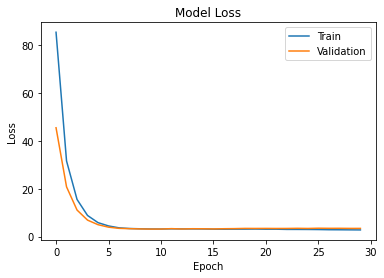

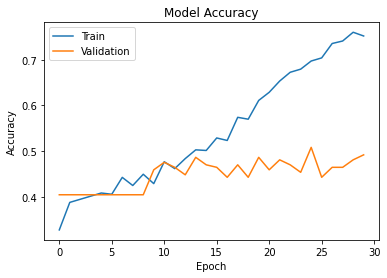

In [ ]:
# 32 64 64 

hist_nf1 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=30, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

Epoch 1/40
23/23 [==============================] - 13s 393ms/step - loss: 67.2558 - accuracy: 0.3411 - val_loss: 42.2112 - val_accuracy: 0.2623
Epoch 2/40
23/23 [==============================] - 7s 293ms/step - loss: 29.5572 - accuracy: 0.3123 - val_loss: 20.6519 - val_accuracy: 0.4044
Epoch 3/40
23/23 [==============================] - 7s 295ms/step - loss: 16.3160 - accuracy: 0.4123 - val_loss: 12.6802 - val_accuracy: 0.4044
Epoch 4/40
23/23 [==============================] - 7s 296ms/step - loss: 10.6980 - accuracy: 0.3849 - val_loss: 8.8813 - val_accuracy: 0.4044
Epoch 5/40
23/23 [==============================] - 7s 300ms/step - loss: 7.7401 - accuracy: 0.4301 - val_loss: 6.6611 - val_accuracy: 0.4044
Epoch 6/40
23/23 [==============================] - 7s 300ms/step - loss: 5.9524 - accuracy: 0.4260 - val_loss: 5.3369 - val_accuracy: 0.4044
Epoch 7/40
23/23 [==============================] - 7s 300ms/step - loss: 4.8848 - accuracy: 0.4178 - val_loss: 4.4694 - val_accuracy: 0.404

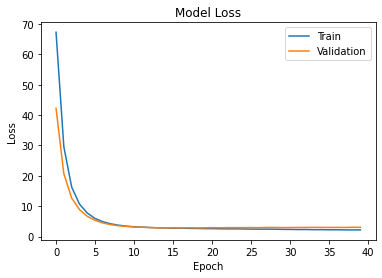

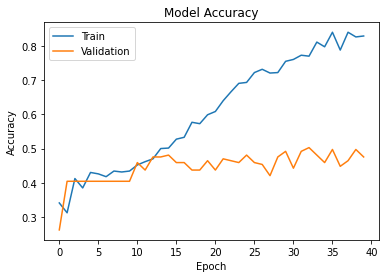

In [ ]:
# 128 64 32

hist_nf1 = History()
model = create_model(64, 64, 32, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

Epoch 1/40
23/23 [==============================] - 11s 287ms/step - loss: 51.2353 - accuracy: 0.3233 - val_loss: 36.1992 - val_accuracy: 0.3934
Epoch 2/40
23/23 [==============================] - 5s 207ms/step - loss: 26.4208 - accuracy: 0.4110 - val_loss: 17.5835 - val_accuracy: 0.4044
Epoch 3/40
23/23 [==============================] - 5s 206ms/step - loss: 13.4105 - accuracy: 0.4329 - val_loss: 10.3245 - val_accuracy: 0.4098
Epoch 4/40
23/23 [==============================] - 5s 208ms/step - loss: 8.6472 - accuracy: 0.4356 - val_loss: 7.2137 - val_accuracy: 0.4153
Epoch 5/40
23/23 [==============================] - 5s 208ms/step - loss: 6.3414 - accuracy: 0.4521 - val_loss: 5.5582 - val_accuracy: 0.4044
Epoch 6/40
23/23 [==============================] - 5s 208ms/step - loss: 4.9885 - accuracy: 0.4438 - val_loss: 4.5206 - val_accuracy: 0.4372
Epoch 7/40
23/23 [==============================] - 5s 209ms/step - loss: 4.1386 - accuracy: 0.4767 - val_loss: 3.8134 - val_accuracy: 0.4262

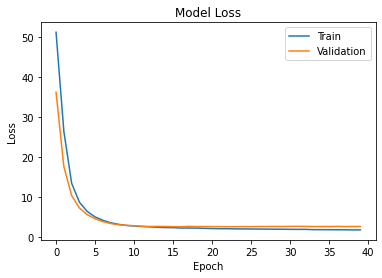

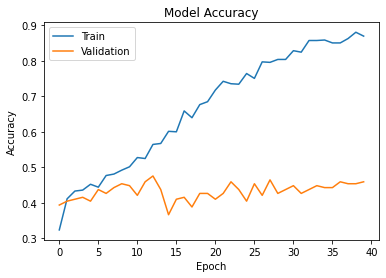

In [ ]:
# 128 64 32

hist_nf1 = History()
model = create_model(64, 32, 16, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

# Filter Kernel Size

Epoch 1/40
23/23 [==============================] - 9s 237ms/step - loss: 35.6179 - accuracy: 0.3753 - val_loss: 19.5085 - val_accuracy: 0.4426
Epoch 2/40
23/23 [==============================] - 4s 154ms/step - loss: 12.9706 - accuracy: 0.4068 - val_loss: 8.0771 - val_accuracy: 0.4426
Epoch 3/40
23/23 [==============================] - 4s 158ms/step - loss: 5.9786 - accuracy: 0.4041 - val_loss: 4.3001 - val_accuracy: 0.4426
Epoch 4/40
23/23 [==============================] - 4s 155ms/step - loss: 3.6442 - accuracy: 0.3932 - val_loss: 3.1630 - val_accuracy: 0.4426
Epoch 5/40
23/23 [==============================] - 4s 154ms/step - loss: 3.0533 - accuracy: 0.4068 - val_loss: 3.0309 - val_accuracy: 0.1694
Epoch 6/40
23/23 [==============================] - 4s 153ms/step - loss: 3.1416 - accuracy: 0.4055 - val_loss: 2.8287 - val_accuracy: 0.4426
Epoch 7/40
23/23 [==============================] - 3s 152ms/step - loss: 2.6627 - accuracy: 0.4219 - val_loss: 2.5289 - val_accuracy: 0.4426
Epo

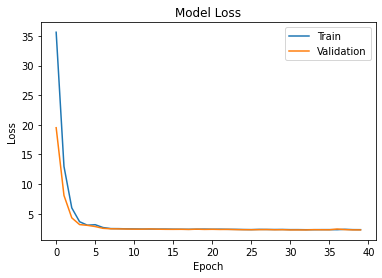

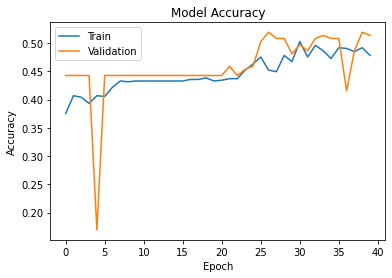

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (5, 5), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 47, 40, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(7, 7), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_ks3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_ks3])
plothist(hist_ks3)

Epoch 1/40
23/23 [==============================] - 7s 166ms/step - loss: 35.8246 - accuracy: 0.3205 - val_loss: 20.5404 - val_accuracy: 0.4426
Epoch 2/40
23/23 [==============================] - 3s 134ms/step - loss: 14.9815 - accuracy: 0.2425 - val_loss: 10.2048 - val_accuracy: 0.4426
Epoch 3/40
23/23 [==============================] - 3s 133ms/step - loss: 7.8531 - accuracy: 0.3342 - val_loss: 5.8269 - val_accuracy: 0.4426
Epoch 4/40
23/23 [==============================] - 3s 133ms/step - loss: 4.8904 - accuracy: 0.3836 - val_loss: 3.9626 - val_accuracy: 0.4426
Epoch 5/40
23/23 [==============================] - 3s 133ms/step - loss: 3.5508 - accuracy: 0.4301 - val_loss: 3.1323 - val_accuracy: 0.4426
Epoch 6/40
23/23 [==============================] - 3s 134ms/step - loss: 2.9136 - accuracy: 0.4315 - val_loss: 2.6982 - val_accuracy: 0.4426
Epoch 7/40
23/23 [==============================] - 3s 134ms/step - loss: 2.6219 - accuracy: 0.4329 - val_loss: 2.5652 - val_accuracy: 0.4426
Ep

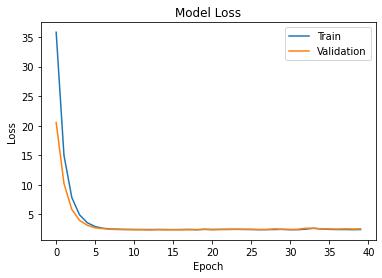

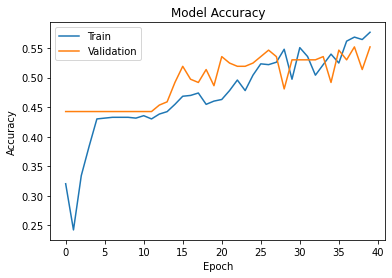

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 48, 41, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(5, 5), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_ks3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=55, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_ks3])
plothist(hist_ks3)

Epoch 1/40
23/23 [==============================] - 7s 173ms/step - loss: 34.0876 - accuracy: 0.3438 - val_loss: 19.3846 - val_accuracy: 0.4426
Epoch 2/40
23/23 [==============================] - 3s 139ms/step - loss: 13.9712 - accuracy: 0.4247 - val_loss: 9.4513 - val_accuracy: 0.4426
Epoch 3/40
23/23 [==============================] - 3s 139ms/step - loss: 7.2436 - accuracy: 0.4288 - val_loss: 5.3390 - val_accuracy: 0.4426
Epoch 4/40
23/23 [==============================] - 3s 139ms/step - loss: 4.3913 - accuracy: 0.4301 - val_loss: 3.5785 - val_accuracy: 0.4426
Epoch 5/40
23/23 [==============================] - 3s 140ms/step - loss: 3.2077 - accuracy: 0.4342 - val_loss: 2.8640 - val_accuracy: 0.4536
Epoch 6/40
23/23 [==============================] - 3s 139ms/step - loss: 2.7470 - accuracy: 0.4411 - val_loss: 2.5948 - val_accuracy: 0.4481
Epoch 7/40
23/23 [==============================] - 3s 140ms/step - loss: 2.5701 - accuracy: 0.4397 - val_loss: 2.4929 - val_accuracy: 0.4481
Epo

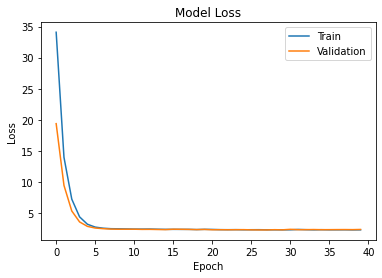

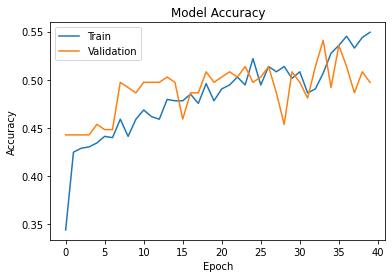

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (5, 5), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 47, 40, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(5, 5), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_ks3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_ks3])
plothist(hist_ks3)

Epoch 1/40
23/23 [==============================] - 7s 182ms/step - loss: 33.3912 - accuracy: 0.3288 - val_loss: 18.0694 - val_accuracy: 0.4426
Epoch 2/40
23/23 [==============================] - 3s 144ms/step - loss: 12.9368 - accuracy: 0.4123 - val_loss: 8.7028 - val_accuracy: 0.4426
Epoch 3/40
23/23 [==============================] - 3s 145ms/step - loss: 6.8748 - accuracy: 0.3685 - val_loss: 5.2023 - val_accuracy: 0.4426
Epoch 4/40
23/23 [==============================] - 3s 146ms/step - loss: 4.4521 - accuracy: 0.3945 - val_loss: 3.7434 - val_accuracy: 0.4426
Epoch 5/40
23/23 [==============================] - 3s 147ms/step - loss: 3.3991 - accuracy: 0.4014 - val_loss: 3.0360 - val_accuracy: 0.4426
Epoch 6/40
23/23 [==============================] - 3s 147ms/step - loss: 2.9305 - accuracy: 0.4110 - val_loss: 2.8337 - val_accuracy: 0.4426
Epoch 7/40
23/23 [==============================] - 3s 148ms/step - loss: 2.7559 - accuracy: 0.4329 - val_loss: 2.6153 - val_accuracy: 0.4426
Epo

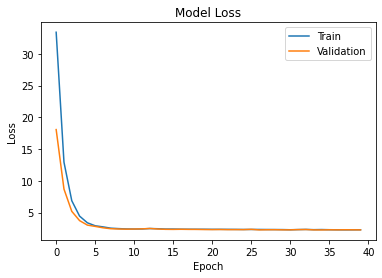

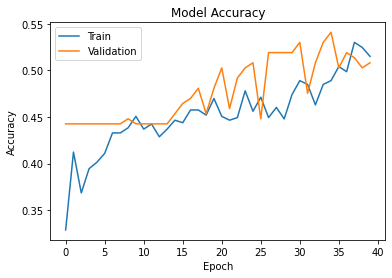

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 48, 41, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(7, 7), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_ks3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_ks3])
plothist(hist_ks3)

Epoch 1/40
23/23 [==============================] - 7s 202ms/step - loss: 36.5873 - accuracy: 0.3603 - val_loss: 21.0717 - val_accuracy: 0.4426
Epoch 2/40
23/23 [==============================] - 4s 161ms/step - loss: 15.0855 - accuracy: 0.4329 - val_loss: 10.1018 - val_accuracy: 0.4426
Epoch 3/40
23/23 [==============================] - 4s 158ms/step - loss: 7.6861 - accuracy: 0.4329 - val_loss: 5.6840 - val_accuracy: 0.4426
Epoch 4/40
23/23 [==============================] - 4s 159ms/step - loss: 4.7163 - accuracy: 0.4329 - val_loss: 3.8748 - val_accuracy: 0.4426
Epoch 5/40
23/23 [==============================] - 4s 162ms/step - loss: 3.4582 - accuracy: 0.4329 - val_loss: 3.0882 - val_accuracy: 0.4426
Epoch 6/40
23/23 [==============================] - 4s 160ms/step - loss: 2.8980 - accuracy: 0.4329 - val_loss: 2.7134 - val_accuracy: 0.4426
Epoch 7/40
23/23 [==============================] - 4s 157ms/step - loss: 2.6475 - accuracy: 0.4329 - val_loss: 2.5585 - val_accuracy: 0.4426
Ep

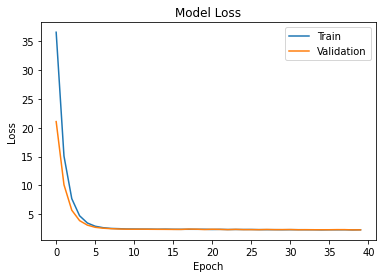

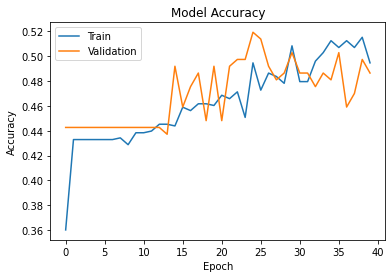

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (5, 5), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (5, 5), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 47, 40, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(7, 7), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_ks3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_ks3])
plothist(hist_ks3)

Epoch 1/40
23/23 [==============================] - 10s 268ms/step - loss: 31.2909 - accuracy: 0.3644 - val_loss: 16.7611 - val_accuracy: 0.4426
Epoch 2/40
23/23 [==============================] - 4s 172ms/step - loss: 12.1762 - accuracy: 0.4055 - val_loss: 8.5154 - val_accuracy: 0.4426
Epoch 3/40
23/23 [==============================] - 4s 173ms/step - loss: 6.8159 - accuracy: 0.4205 - val_loss: 5.4479 - val_accuracy: 0.4426
Epoch 4/40
23/23 [==============================] - 4s 173ms/step - loss: 4.7228 - accuracy: 0.4329 - val_loss: 4.0421 - val_accuracy: 0.4426
Epoch 5/40
23/23 [==============================] - 4s 171ms/step - loss: 3.6902 - accuracy: 0.4329 - val_loss: 3.4322 - val_accuracy: 0.4426
Epoch 6/40
23/23 [==============================] - 4s 171ms/step - loss: 3.3888 - accuracy: 0.4260 - val_loss: 3.2023 - val_accuracy: 0.4426
Epoch 7/40
23/23 [==============================] - 4s 169ms/step - loss: 3.0339 - accuracy: 0.4356 - val_loss: 2.8330 - val_accuracy: 0.4426
Ep

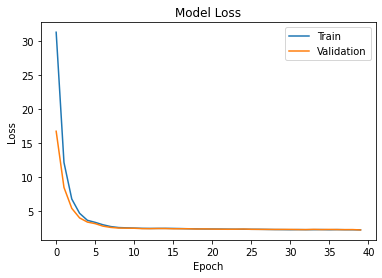

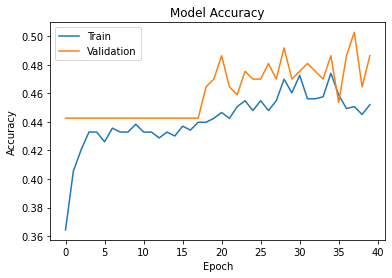

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (5, 5), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (7, 7), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 46, 40, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(7, 7), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_ks3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_ks3])
plothist(hist_ks3)

Epoch 1/40
23/23 [==============================] - 11s 285ms/step - loss: 34.7477 - accuracy: 0.3616 - val_loss: 20.5066 - val_accuracy: 0.4536
Epoch 2/40
23/23 [==============================] - 4s 177ms/step - loss: 14.5122 - accuracy: 0.4288 - val_loss: 9.6848 - val_accuracy: 0.4426
Epoch 3/40
23/23 [==============================] - 4s 178ms/step - loss: 7.3214 - accuracy: 0.4425 - val_loss: 5.4076 - val_accuracy: 0.4481
Epoch 4/40
23/23 [==============================] - 4s 180ms/step - loss: 4.5027 - accuracy: 0.4466 - val_loss: 3.7179 - val_accuracy: 0.4699
Epoch 5/40
23/23 [==============================] - 4s 180ms/step - loss: 3.3944 - accuracy: 0.4616 - val_loss: 3.1329 - val_accuracy: 0.4426
Epoch 6/40
23/23 [==============================] - 4s 179ms/step - loss: 2.9550 - accuracy: 0.4329 - val_loss: 2.7644 - val_accuracy: 0.4426
Epoch 7/40
23/23 [==============================] - 4s 178ms/step - loss: 2.7095 - accuracy: 0.4452 - val_loss: 2.6214 - val_accuracy: 0.4481
Ep

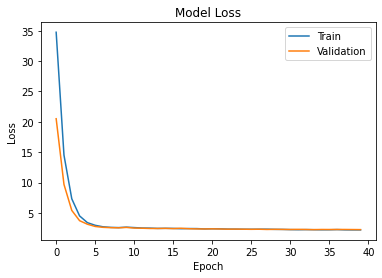

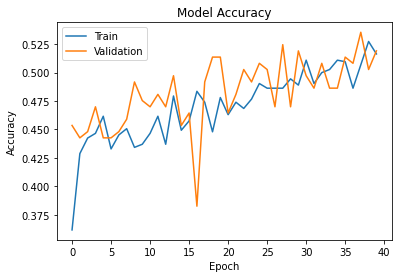

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (7, 7), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (7, 7), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 46, 39, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(7, 7), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_ks3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_ks3])
plothist(hist_ks3)

Epoch 1/40
23/23 [==============================] - 6s 171ms/step - loss: 32.2053 - accuracy: 0.3575 - val_loss: 17.0904 - val_accuracy: 0.4426
Epoch 2/40
23/23 [==============================] - 3s 143ms/step - loss: 11.7850 - accuracy: 0.4205 - val_loss: 7.5815 - val_accuracy: 0.4426
Epoch 3/40
23/23 [==============================] - 3s 144ms/step - loss: 5.7504 - accuracy: 0.4301 - val_loss: 4.2946 - val_accuracy: 0.4426
Epoch 4/40
23/23 [==============================] - 3s 144ms/step - loss: 3.6706 - accuracy: 0.4192 - val_loss: 3.1084 - val_accuracy: 0.4426
Epoch 5/40
23/23 [==============================] - 3s 145ms/step - loss: 2.9082 - accuracy: 0.4329 - val_loss: 2.6802 - val_accuracy: 0.4426
Epoch 6/40
23/23 [==============================] - 3s 144ms/step - loss: 2.6195 - accuracy: 0.4329 - val_loss: 2.5098 - val_accuracy: 0.4426
Epoch 7/40
23/23 [==============================] - 3s 146ms/step - loss: 2.4890 - accuracy: 0.4356 - val_loss: 2.4545 - val_accuracy: 0.4426
Epo

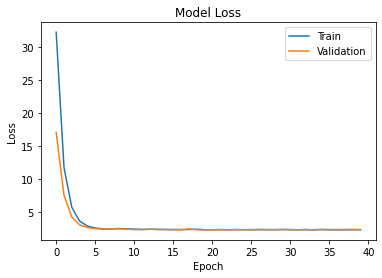

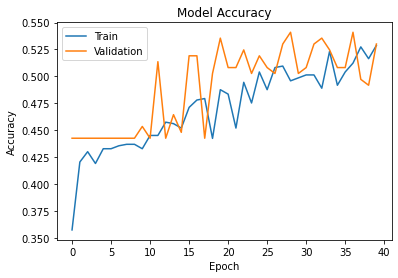

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (5, 5), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (5, 5), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 47, 40, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(5, 5), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_ks3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_ks3])
plothist(hist_ks3)

Epoch 1/55
23/23 [==============================] - 16s 206ms/step - loss: 29.8812 - accuracy: 0.3493 - val_loss: 15.7049 - val_accuracy: 0.2568
Epoch 2/55
23/23 [==============================] - 3s 129ms/step - loss: 11.3904 - accuracy: 0.4055 - val_loss: 7.9532 - val_accuracy: 0.4645
Epoch 3/55
23/23 [==============================] - 3s 128ms/step - loss: 6.2737 - accuracy: 0.4342 - val_loss: 4.9845 - val_accuracy: 0.3333
Epoch 4/55
23/23 [==============================] - 3s 129ms/step - loss: 4.2726 - accuracy: 0.4233 - val_loss: 3.6687 - val_accuracy: 0.4645
Epoch 5/55
23/23 [==============================] - 3s 129ms/step - loss: 3.3387 - accuracy: 0.4260 - val_loss: 3.0381 - val_accuracy: 0.4645
Epoch 6/55
23/23 [==============================] - 3s 130ms/step - loss: 2.9200 - accuracy: 0.4466 - val_loss: 2.7931 - val_accuracy: 0.4645
Epoch 7/55
23/23 [==============================] - 3s 130ms/step - loss: 2.6968 - accuracy: 0.4384 - val_loss: 2.6343 - val_accuracy: 0.4699
Ep

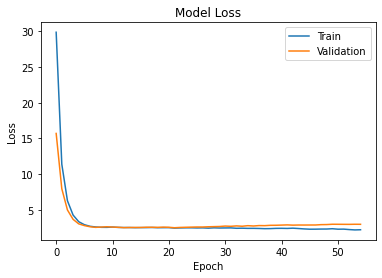

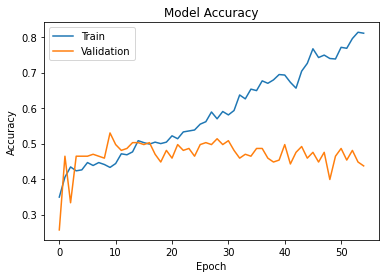

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 48, 41, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(5, 5), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

hist_ks3 = History()
model = create_model(32, 64, 64, 128, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=55, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_ks3])
plothist(hist_ks3)

# Classification block

Epoch 1/50
23/23 [==============================] - 18s 607ms/step - loss: 54.2574 - accuracy: 0.3507 - val_loss: 26.5503 - val_accuracy: 0.4372
Epoch 2/50
23/23 [==============================] - 13s 578ms/step - loss: 18.1839 - accuracy: 0.3397 - val_loss: 11.2321 - val_accuracy: 0.4372
Epoch 3/50
23/23 [==============================] - 13s 585ms/step - loss: 8.3012 - accuracy: 0.3767 - val_loss: 5.9521 - val_accuracy: 0.4372
Epoch 4/50
23/23 [==============================] - 13s 587ms/step - loss: 4.9297 - accuracy: 0.3932 - val_loss: 4.1525 - val_accuracy: 0.4372
Epoch 5/50
23/23 [==============================] - 13s 585ms/step - loss: 3.8228 - accuracy: 0.3945 - val_loss: 3.5102 - val_accuracy: 0.4372
Epoch 6/50
23/23 [==============================] - 13s 583ms/step - loss: 3.3713 - accuracy: 0.4041 - val_loss: 3.1442 - val_accuracy: 0.4372
Epoch 7/50
23/23 [==============================] - 13s 581ms/step - loss: 3.1298 - accuracy: 0.4370 - val_loss: 3.0728 - val_accuracy: 0.

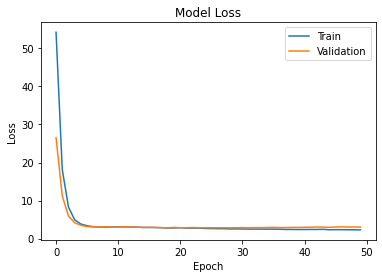

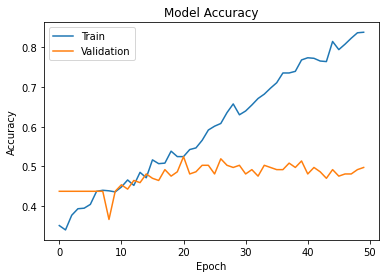

In [ ]:
# 64

hist_nf1 = History()
model = create_model(32, 64, 128, 64, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

Epoch 1/30
23/23 [==============================] - 16s 579ms/step - loss: 30.1364 - accuracy: 0.3123 - val_loss: 16.6501 - val_accuracy: 0.4372
Epoch 2/30
23/23 [==============================] - 13s 560ms/step - loss: 12.2486 - accuracy: 0.3918 - val_loss: 8.8911 - val_accuracy: 0.4372
Epoch 3/30
23/23 [==============================] - 13s 552ms/step - loss: 6.9501 - accuracy: 0.4247 - val_loss: 5.2972 - val_accuracy: 0.4372
Epoch 4/30
23/23 [==============================] - 13s 554ms/step - loss: 4.5971 - accuracy: 0.3397 - val_loss: 3.9714 - val_accuracy: 0.4372
Epoch 5/30
23/23 [==============================] - 13s 558ms/step - loss: 3.5508 - accuracy: 0.4096 - val_loss: 3.1831 - val_accuracy: 0.4372
Epoch 6/30
23/23 [==============================] - 13s 560ms/step - loss: 3.1745 - accuracy: 0.4041 - val_loss: 3.3264 - val_accuracy: 0.1093
Epoch 7/30
23/23 [==============================] - 13s 561ms/step - loss: 3.1209 - accuracy: 0.3849 - val_loss: 3.0090 - val_accuracy: 0.4

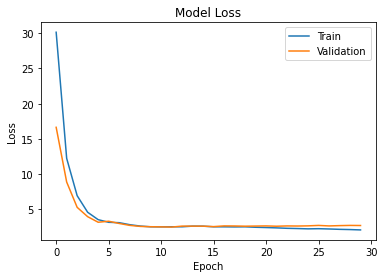

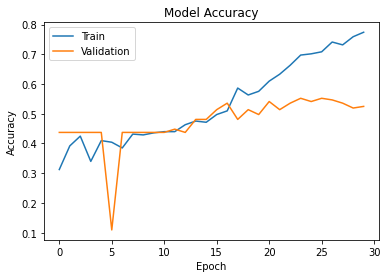

In [ ]:
# 32
hist_nf1 = History()
model = create_model(32, 64, 128, 32, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=30, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

Epoch 1/30
23/23 [==============================] - 26s 756ms/step - loss: 107.0070 - accuracy: 0.2945 - val_loss: 51.1461 - val_accuracy: 0.4973
Epoch 2/30
23/23 [==============================] - 14s 594ms/step - loss: 34.8677 - accuracy: 0.3315 - val_loss: 21.7393 - val_accuracy: 0.4973
Epoch 3/30
23/23 [==============================] - 14s 597ms/step - loss: 15.9405 - accuracy: 0.3205 - val_loss: 11.1042 - val_accuracy: 0.4973
Epoch 4/30
23/23 [==============================] - 14s 601ms/step - loss: 8.9660 - accuracy: 0.3671 - val_loss: 7.0635 - val_accuracy: 0.4973
Epoch 5/30
23/23 [==============================] - 14s 602ms/step - loss: 6.1719 - accuracy: 0.3630 - val_loss: 5.3477 - val_accuracy: 0.4973
Epoch 6/30
23/23 [==============================] - 14s 609ms/step - loss: 4.9957 - accuracy: 0.3493 - val_loss: 4.5473 - val_accuracy: 0.4973
Epoch 7/30
23/23 [==============================] - 14s 611ms/step - loss: 4.4163 - accuracy: 0.3959 - val_loss: 4.2052 - val_accuracy:

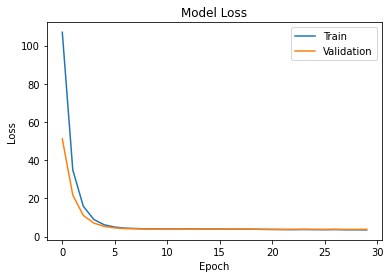

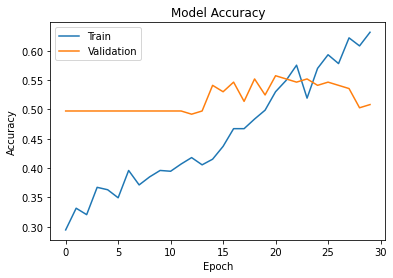

In [ ]:
# 128
hist_nf1 = History()
model = create_model(32, 64, 128, 128, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=30, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 440, 380, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 220, 190, 32)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 218, 188, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 109, 94, 64)      0         
 2D)                                                             
                                                                 
 reshape_6 (Reshape)         (None, 1, 109, 94, 64)    0         
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 1, 109, 94, 128)  

In [ ]:
### Additional dense layer

from keras.layers import Reshape, ConvLSTM2D

def create_model_v1(num_filters_1, num_filters_2, lstm_units, dense_units_1, dense_units_2, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 48, 41, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units_1, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units_2, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Epoch 1/50
23/23 [==============================] - 6s 146ms/step - loss: 32.8314 - accuracy: 0.2616 - val_loss: 17.1997 - val_accuracy: 0.4645
Epoch 2/50
23/23 [==============================] - 3s 118ms/step - loss: 11.4342 - accuracy: 0.4041 - val_loss: 7.2208 - val_accuracy: 0.4645
Epoch 3/50
23/23 [==============================] - 3s 117ms/step - loss: 5.7222 - accuracy: 0.4041 - val_loss: 4.6437 - val_accuracy: 0.4645
Epoch 4/50
23/23 [==============================] - 3s 117ms/step - loss: 4.2885 - accuracy: 0.4274 - val_loss: 4.0055 - val_accuracy: 0.4645
Epoch 5/50
23/23 [==============================] - 3s 117ms/step - loss: 3.9424 - accuracy: 0.4260 - val_loss: 3.8314 - val_accuracy: 0.4645
Epoch 6/50
23/23 [==============================] - 3s 118ms/step - loss: 3.8128 - accuracy: 0.4384 - val_loss: 3.7746 - val_accuracy: 0.4645
Epoch 7/50
23/23 [==============================] - 3s 118ms/step - loss: 3.7738 - accuracy: 0.4411 - val_loss: 3.7528 - val_accuracy: 0.4645
Epo

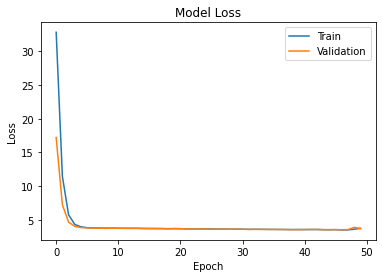

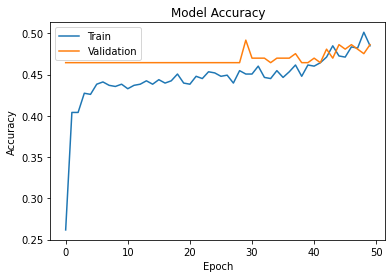

In [ ]:
hist_nf1 = History()
model = create_model_v1(32, 64, 64, 128, 64, 0.5, 0.001, 0.001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

Epoch 1/40
23/23 [==============================] - 6s 142ms/step - loss: 18.7839 - accuracy: 0.3192 - val_loss: 11.2898 - val_accuracy: 0.3333
Epoch 2/40
23/23 [==============================] - 3s 114ms/step - loss: 8.2834 - accuracy: 0.3479 - val_loss: 5.8337 - val_accuracy: 0.1803
Epoch 3/40
23/23 [==============================] - 3s 118ms/step - loss: 4.6490 - accuracy: 0.3493 - val_loss: 3.6976 - val_accuracy: 0.1858
Epoch 4/40
23/23 [==============================] - 3s 121ms/step - loss: 3.2276 - accuracy: 0.3890 - val_loss: 2.8290 - val_accuracy: 0.4645
Epoch 5/40
23/23 [==============================] - 3s 116ms/step - loss: 2.6472 - accuracy: 0.3986 - val_loss: 2.4851 - val_accuracy: 0.4645
Epoch 6/40
23/23 [==============================] - 3s 116ms/step - loss: 2.4113 - accuracy: 0.4219 - val_loss: 2.3186 - val_accuracy: 0.4645
Epoch 7/40
23/23 [==============================] - 3s 116ms/step - loss: 2.3020 - accuracy: 0.4082 - val_loss: 2.2524 - val_accuracy: 0.4645
Epoc

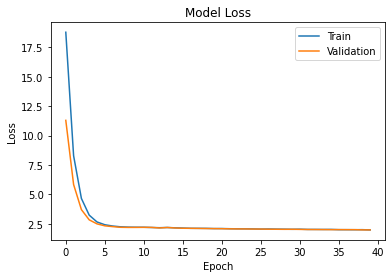

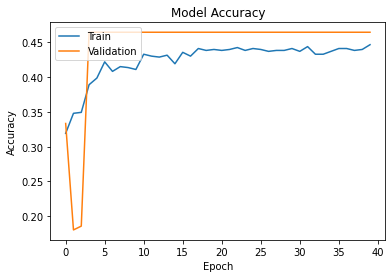

In [ ]:
hist_nf1 = History()
model = create_model_v1(32, 64, 64, 64, 32, 0.5, 0.001, 0.0005)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

Epoch 1/40
23/23 [==============================] - 6s 146ms/step - loss: 91.9707 - accuracy: 0.2795 - val_loss: 62.5563 - val_accuracy: 0.4645
Epoch 2/40
23/23 [==============================] - 3s 116ms/step - loss: 44.0898 - accuracy: 0.3274 - val_loss: 27.9017 - val_accuracy: 0.4645
Epoch 3/40
23/23 [==============================] - 3s 116ms/step - loss: 20.7060 - accuracy: 0.3712 - val_loss: 15.7952 - val_accuracy: 0.4645
Epoch 4/40
23/23 [==============================] - 3s 116ms/step - loss: 13.9214 - accuracy: 0.3973 - val_loss: 12.4978 - val_accuracy: 0.4645
Epoch 5/40
23/23 [==============================] - 3s 117ms/step - loss: 12.0196 - accuracy: 0.4192 - val_loss: 10.8191 - val_accuracy: 0.4645
Epoch 6/40
23/23 [==============================] - 3s 118ms/step - loss: 11.0745 - accuracy: 0.4370 - val_loss: 10.6579 - val_accuracy: 0.4645
Epoch 7/40
23/23 [==============================] - 3s 118ms/step - loss: 11.0948 - accuracy: 0.4164 - val_loss: 11.1836 - val_accuracy:

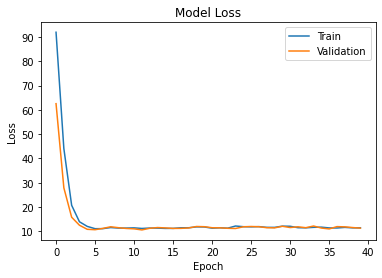

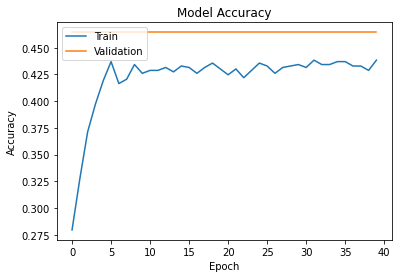

In [ ]:
hist_nf1 = History()
model = create_model_v1(32, 64, 64, 128, 32, 0.5, 0.001, 0.005)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_nf1])
plothist(hist_nf1)

In [ ]:
# LSTM-FC checked in other notebooks

# Regularisation


In [ ]:
def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Reshape((-1, 109, 94, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
def create_model2(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l2(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l2(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Reshape((-1, 109, 94, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Epoch 1/50
23/23 [==============================] - 23s 445ms/step - loss: 342.9821 - accuracy: 0.3137 - val_loss: 111.0908 - val_accuracy: 0.4317
Epoch 2/50
23/23 [==============================] - 8s 344ms/step - loss: 62.0955 - accuracy: 0.3726 - val_loss: 31.4118 - val_accuracy: 0.4317
Epoch 3/50
23/23 [==============================] - 8s 347ms/step - loss: 22.0033 - accuracy: 0.4082 - val_loss: 16.0252 - val_accuracy: 0.4317
Epoch 4/50
23/23 [==============================] - 8s 348ms/step - loss: 14.6170 - accuracy: 0.3932 - val_loss: 13.6290 - val_accuracy: 0.4317
Epoch 5/50
23/23 [==============================] - 8s 351ms/step - loss: 13.1991 - accuracy: 0.4247 - val_loss: 12.8538 - val_accuracy: 0.4317
Epoch 6/50
23/23 [==============================] - 8s 353ms/step - loss: 12.6962 - accuracy: 0.4014 - val_loss: 12.5050 - val_accuracy: 0.4317
Epoch 7/50
23/23 [==============================] - 8s 355ms/step - loss: 12.2818 - accuracy: 0.4027 - val_loss: 12.0641 - val_accura

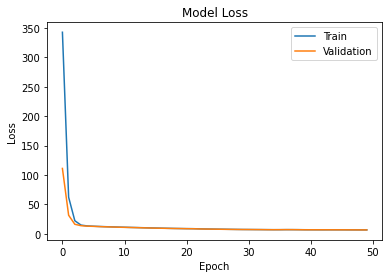

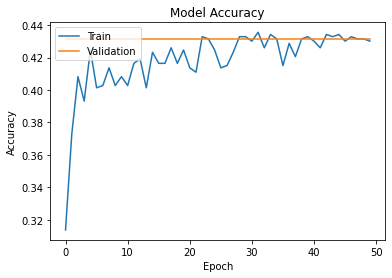

In [ ]:
hist_dr1 = History()
model = create_model(32, 64, 64, 64, 0.5, 0.01, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_dr1])
plothist(hist_dr1)

Epoch 1/50
23/23 [==============================] - 11s 370ms/step - loss: 43.1691 - accuracy: 0.3123 - val_loss: 22.2666 - val_accuracy: 0.4317
Epoch 2/50
23/23 [==============================] - 8s 344ms/step - loss: 16.2915 - accuracy: 0.3205 - val_loss: 11.7770 - val_accuracy: 0.4317
Epoch 3/50
23/23 [==============================] - 8s 349ms/step - loss: 9.5794 - accuracy: 0.3808 - val_loss: 7.7238 - val_accuracy: 0.4317
Epoch 4/50
23/23 [==============================] - 8s 349ms/step - loss: 6.7612 - accuracy: 0.3671 - val_loss: 5.8363 - val_accuracy: 0.4317
Epoch 5/50
23/23 [==============================] - 8s 349ms/step - loss: 5.3375 - accuracy: 0.3781 - val_loss: 4.7003 - val_accuracy: 0.4317
Epoch 6/50
23/23 [==============================] - 8s 349ms/step - loss: 4.3563 - accuracy: 0.4137 - val_loss: 3.9747 - val_accuracy: 0.4317
Epoch 7/50
23/23 [==============================] - 8s 349ms/step - loss: 3.7499 - accuracy: 0.4178 - val_loss: 3.5507 - val_accuracy: 0.4317
E

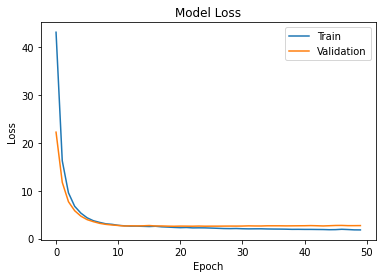

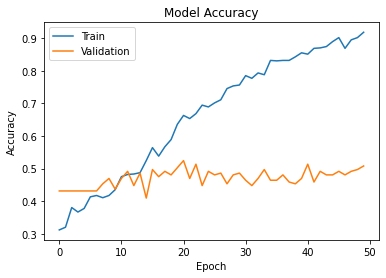

In [ ]:
hist_dr1 = History()
model = create_model(32, 64, 64, 64, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_dr1])
plothist(hist_dr1)

Epoch 1/50
23/23 [==============================] - 12s 372ms/step - loss: 8.2092 - accuracy: 0.2863 - val_loss: 5.3441 - val_accuracy: 0.3443
Epoch 2/50
23/23 [==============================] - 8s 341ms/step - loss: 4.9213 - accuracy: 0.3849 - val_loss: 4.4771 - val_accuracy: 0.1585
Epoch 3/50
23/23 [==============================] - 8s 338ms/step - loss: 4.1634 - accuracy: 0.4205 - val_loss: 3.8592 - val_accuracy: 0.4317
Epoch 4/50
23/23 [==============================] - 8s 336ms/step - loss: 3.6490 - accuracy: 0.4329 - val_loss: 3.4353 - val_accuracy: 0.4317
Epoch 5/50
23/23 [==============================] - 8s 338ms/step - loss: 3.2846 - accuracy: 0.4123 - val_loss: 3.1276 - val_accuracy: 0.4317
Epoch 6/50
23/23 [==============================] - 8s 336ms/step - loss: 3.0045 - accuracy: 0.4247 - val_loss: 2.8757 - val_accuracy: 0.4317
Epoch 7/50
23/23 [==============================] - 8s 343ms/step - loss: 2.8263 - accuracy: 0.3890 - val_loss: 2.7287 - val_accuracy: 0.4317
Epoch

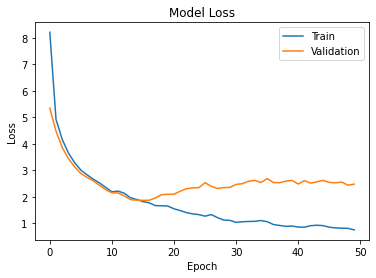

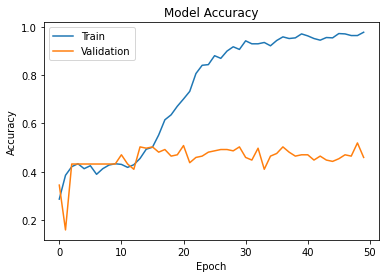

In [ ]:
hist_dr1 = History()
model = create_model(32, 64, 64, 64, 0.5, 0.0001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_dr1])
plothist(hist_dr1)

Epoch 1/50
23/23 [==============================] - 11s 367ms/step - loss: 4.6589 - accuracy: 0.3274 - val_loss: 2.5275 - val_accuracy: 0.4317
Epoch 2/50
23/23 [==============================] - 8s 337ms/step - loss: 2.5223 - accuracy: 0.4205 - val_loss: 2.4627 - val_accuracy: 0.4317
Epoch 3/50
23/23 [==============================] - 8s 334ms/step - loss: 2.4220 - accuracy: 0.4301 - val_loss: 2.3793 - val_accuracy: 0.4317
Epoch 4/50
23/23 [==============================] - 8s 338ms/step - loss: 2.3441 - accuracy: 0.4329 - val_loss: 2.2783 - val_accuracy: 0.4317
Epoch 5/50
23/23 [==============================] - 8s 334ms/step - loss: 2.2803 - accuracy: 0.4329 - val_loss: 2.2498 - val_accuracy: 0.4317
Epoch 6/50
23/23 [==============================] - 8s 333ms/step - loss: 2.2243 - accuracy: 0.4329 - val_loss: 2.1977 - val_accuracy: 0.4317
Epoch 7/50
23/23 [==============================] - 8s 333ms/step - loss: 2.1754 - accuracy: 0.4329 - val_loss: 2.1505 - val_accuracy: 0.4317
Epoch

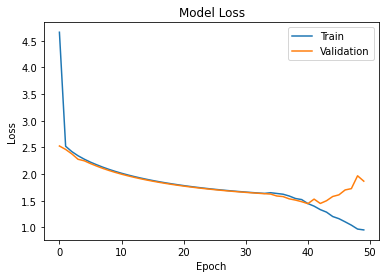

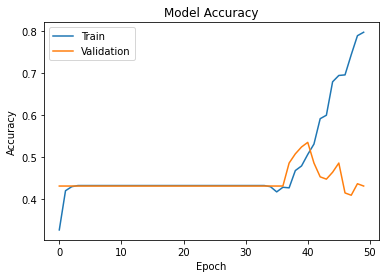

In [ ]:
hist_dr1 = History()
model = create_model2(32, 64, 64, 64, 0.5, 0.01, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_dr1])
plothist(hist_dr1)

Epoch 1/50
23/23 [==============================] - 11s 368ms/step - loss: 2.5238 - accuracy: 0.3219 - val_loss: 1.4583 - val_accuracy: 0.4317
Epoch 2/50
23/23 [==============================] - 8s 341ms/step - loss: 1.5223 - accuracy: 0.3877 - val_loss: 1.4922 - val_accuracy: 0.4317
Epoch 3/50
23/23 [==============================] - 8s 336ms/step - loss: 1.5027 - accuracy: 0.4329 - val_loss: 1.4989 - val_accuracy: 0.4317
Epoch 4/50
23/23 [==============================] - 8s 332ms/step - loss: 1.4967 - accuracy: 0.4329 - val_loss: 1.4942 - val_accuracy: 0.4317
Epoch 5/50
23/23 [==============================] - 8s 333ms/step - loss: 1.4922 - accuracy: 0.4329 - val_loss: 1.4898 - val_accuracy: 0.4317
Epoch 6/50
23/23 [==============================] - 8s 333ms/step - loss: 1.4879 - accuracy: 0.4329 - val_loss: 1.4857 - val_accuracy: 0.4317
Epoch 7/50
23/23 [==============================] - 8s 332ms/step - loss: 1.4840 - accuracy: 0.4329 - val_loss: 1.4819 - val_accuracy: 0.4317
Epoch

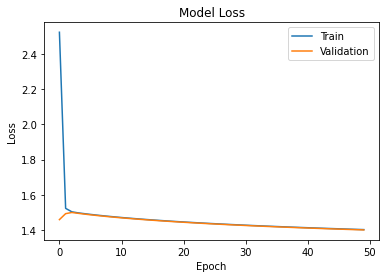

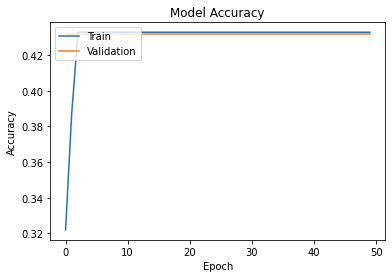

In [ ]:
hist_dr1 = History()
model = create_model2(32, 64, 64, 64, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_dr1])
plothist(hist_dr1)

Epoch 1/50
23/23 [==============================] - 11s 369ms/step - loss: 3.3835 - accuracy: 0.2753 - val_loss: 1.4025 - val_accuracy: 0.4317
Epoch 2/50
23/23 [==============================] - 8s 331ms/step - loss: 1.4019 - accuracy: 0.4329 - val_loss: 1.4012 - val_accuracy: 0.4317
Epoch 3/50
23/23 [==============================] - 8s 332ms/step - loss: 1.4008 - accuracy: 0.4329 - val_loss: 1.4002 - val_accuracy: 0.4317
Epoch 4/50
23/23 [==============================] - 8s 333ms/step - loss: 1.4073 - accuracy: 0.4329 - val_loss: 1.3994 - val_accuracy: 0.4317
Epoch 5/50
23/23 [==============================] - 8s 333ms/step - loss: 1.4223 - accuracy: 0.4205 - val_loss: 1.3987 - val_accuracy: 0.4317
Epoch 6/50
23/23 [==============================] - 8s 335ms/step - loss: 1.4473 - accuracy: 0.4219 - val_loss: 1.3980 - val_accuracy: 0.4317
Epoch 7/50
23/23 [==============================] - 8s 333ms/step - loss: 1.4220 - accuracy: 0.4301 - val_loss: 1.3974 - val_accuracy: 0.4317
Epoch

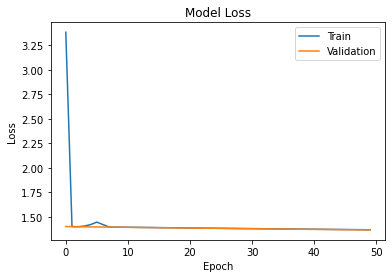

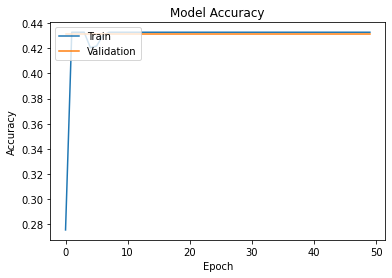

In [ ]:
hist_dr1 = History()
model = create_model2(32, 64, 64, 64, 0.5, 0.0001, 0.0001)
model.fit(X_train, y_bin, epochs=50, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_dr1])
plothist(hist_dr1)

# Aug

In [ ]:
## Noise + Pitch shifting

In [26]:
import numpy as np

# Adding random Gaussian noise to the input spectrograms and returning the augmented spectrograms and labels
def add_noise(X_train, y_train, noise_factor):
    # Create a new array with the same shape as X_train
    X_train_noisy = np.empty_like(X_train)
    
    # Add Gaussian noise with mean 0 and standard deviation noise_factor
    for i in range(X_train.shape[0]):
        X_train_noisy[i] = X_train[i] + noise_factor * np.random.randn(*X_train[i].shape)
    
    # Clip the resulting values to the range [0, 1]
    #X_train_noisy = np.clip(X_train_noisy, 0., 1.)
    
    # Return the augmented spectrograms and labels
    return X_train_noisy, y_train

# Example usage
noise_factor = 1
X_train_noisy, y_train_augmented = add_noise(X_train, y_train, noise_factor)

In [27]:
X_train_noisy[0]-X_train[0]

array([[-0.66475709, -0.74218333, -0.56963444, ...,  0.29524863,
         1.14410175,  0.11930721],
       [ 0.04115694, -1.31169142,  0.43746269, ...,  1.94390177,
        -2.04313942,  0.54472893],
       [ 0.21017203,  2.17173017,  1.44651994, ...,  0.99852972,
         0.06190823, -1.2983245 ],
       ...,
       [ 0.6579484 ,  0.80511793,  0.30927998, ..., -0.41971393,
         0.24962857, -1.5496123 ],
       [ 1.23246771,  0.39170535,  1.45525832, ...,  0.74982955,
        -0.63969101,  0.98583983],
       [-0.74863023,  1.21307014,  0.42732013, ...,  0.18783225,
         0.22561291, -0.18267671]])

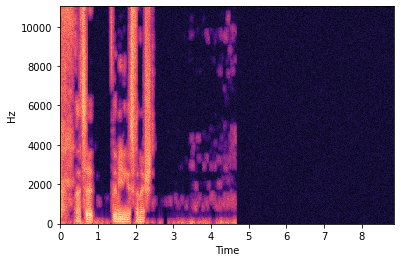

In [28]:
librosa.display.specshow(X_train_noisy[728], sr=22050, x_axis='time', y_axis='hz')


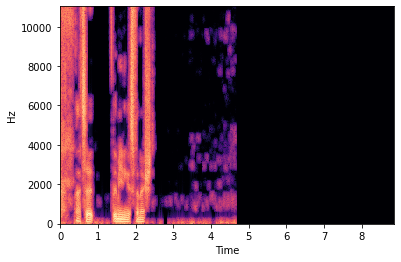

In [23]:
librosa.display.specshow(X_train[728], sr=22050, x_axis='time', y_axis='hz')

/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=382
  warnings.warn(


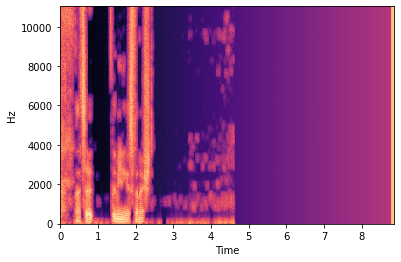

In [24]:
zzz = librosa.effects.pitch_shift(X_train[728],sr=22050, n_steps=3, bins_per_octave=200,)
librosa.display.specshow(zzz, sr=22050, x_axis='time', y_axis='hz')

In [ ]:
def pitch_shift(X_train, n_steps):
    # Create a new array with the same shape as X_train
    X_train_shifted = np.empty_like(X_train)
    
    # Shift the pitch by a random number of steps
    for i in range(X_train.shape[0]):
        n_steps_shift = np.random.randint(-n_steps, n_steps)
        X_train_shifted[i] = librosa.effects.pitch_shift(X_train[i], sr=22050, n_steps=n_steps_shift, bins_per_octave=200)
    
    # Return the augmented spectrograms and labels
    return X_train_shifted

# Example usage
sr = 22050
n_steps = 3
X_train_shifted = pitch_shift(X_train, 3)

In [ ]:
### Noisy dataset

X_noise = np.concatenate((X_train, X_train_noisy), axis = 0)
y_noise = np.concatenate((y_train, y_train), axis=0)
y_noise = label_binarize(y_noise, classes=['angry', 'happy', 'sad', 'neutral',])

In [ ]:
### Shifted dataset

X_shift = np.concatenate((X_train, X_train_shifted), axis = 0)
y_shift = np.concatenate((y_train, y_train), axis=0)
y_shift = label_binarize(y_shift, classes=['angry', 'happy', 'sad', 'neutral',])

In [ ]:
### Shifted + Noisy dataset

X_shiftnoise = np.concatenate((X_train, X_train_shifted, X_train_noisy), axis = 0)
y_shiftnoise = np.concatenate((y_train, y_train, y_train), axis=0)
y_shiftnoise = label_binarize(y_shiftnoise, classes=['angry', 'happy', 'sad', 'neutral',])

In [ ]:
hist_lr1 = History()
model = create_model(32, 64, 64, 32, 0.5, 0.001, 0.0001)
model.fit(X_noise, y_noise, epochs=60, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_lr1])
plothist(hist_lr1)

Epoch 1/60
46/46 [==============================] - 30s 363ms/step - loss: 16.6172 - accuracy: 0.4103 - val_loss: 7.4686 - val_accuracy: 0.3880
Epoch 2/60
46/46 [==============================] - 15s 320ms/step - loss: 5.5008 - accuracy: 0.3486 - val_loss: 4.1423 - val_accuracy: 0.3934
Epoch 3/60
46/46 [==============================] - 15s 328ms/step - loss: 3.6446 - accuracy: 0.3808 - val_loss: 3.1580 - val_accuracy: 0.3934
Epoch 4/60
46/46 [==============================] - 15s 331ms/step - loss: 2.9559 - accuracy: 0.4103 - val_loss: 2.7225 - val_accuracy: 0.3934
Epoch 5/60
46/46 [==============================] - 15s 329ms/step - loss: 2.5623 - accuracy: 0.4534 - val_loss: 2.4623 - val_accuracy: 0.4645
Epoch 6/60
46/46 [==============================] - 15s 329ms/step - loss: 2.4046 - accuracy: 0.5233 - val_loss: 2.3770 - val_accuracy: 0.4809
Epoch 7/60
46/46 [==============================] - 15s 329ms/step - loss: 2.3247 - accuracy: 0.5144 - val_loss: 2.3596 - val_accuracy: 0.480

KeyboardInterrupt: ignored

Epoch 1/20
46/46 [==============================] - 18s 330ms/step - loss: 19.0309 - accuracy: 0.4048 - val_loss: 9.7676 - val_accuracy: 0.3934
Epoch 2/20
46/46 [==============================] - 15s 323ms/step - loss: 6.9945 - accuracy: 0.3870 - val_loss: 5.3864 - val_accuracy: 0.2350
Epoch 3/20
46/46 [==============================] - 15s 325ms/step - loss: 4.3763 - accuracy: 0.3822 - val_loss: 3.5886 - val_accuracy: 0.3934
Epoch 4/20
46/46 [==============================] - 15s 324ms/step - loss: 3.2176 - accuracy: 0.3842 - val_loss: 2.8706 - val_accuracy: 0.1421
Epoch 5/20
46/46 [==============================] - 15s 325ms/step - loss: 2.6927 - accuracy: 0.3589 - val_loss: 2.5636 - val_accuracy: 0.3934
Epoch 6/20
46/46 [==============================] - 15s 326ms/step - loss: 2.4423 - accuracy: 0.4151 - val_loss: 2.3623 - val_accuracy: 0.3934
Epoch 7/20
46/46 [==============================] - 15s 327ms/step - loss: 2.3314 - accuracy: 0.4199 - val_loss: 2.2677 - val_accuracy: 0.464

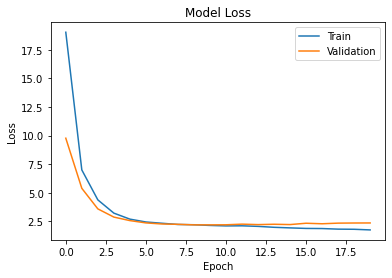

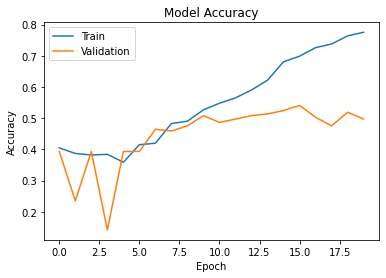

In [ ]:
hist_lr1 = History()
model = create_model(32, 64, 64, 32, 0.5, 0.001, 0.0001)
model.fit(X_shift, y_shift, epochs=20, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_lr1])
plothist(hist_lr1)

Epoch 1/20
69/69 [==============================] - 26s 336ms/step - loss: 14.6993 - accuracy: 0.3479 - val_loss: 6.8849 - val_accuracy: 0.3934
Epoch 2/20
69/69 [==============================] - 22s 322ms/step - loss: 5.1154 - accuracy: 0.4114 - val_loss: 3.8326 - val_accuracy: 0.3716
Epoch 3/20
69/69 [==============================] - 22s 322ms/step - loss: 3.2396 - accuracy: 0.4023 - val_loss: 2.8216 - val_accuracy: 0.4372
Epoch 4/20
69/69 [==============================] - 22s 321ms/step - loss: 2.6125 - accuracy: 0.4443 - val_loss: 2.4008 - val_accuracy: 0.4044
Epoch 5/20
69/69 [==============================] - 22s 322ms/step - loss: 2.3154 - accuracy: 0.4767 - val_loss: 2.1804 - val_accuracy: 0.4809
Epoch 6/20
69/69 [==============================] - 22s 323ms/step - loss: 2.1263 - accuracy: 0.5301 - val_loss: 2.1925 - val_accuracy: 0.4918
Epoch 7/20
69/69 [==============================] - 22s 322ms/step - loss: 2.1130 - accuracy: 0.5676 - val_loss: 2.2435 - val_accuracy: 0.519

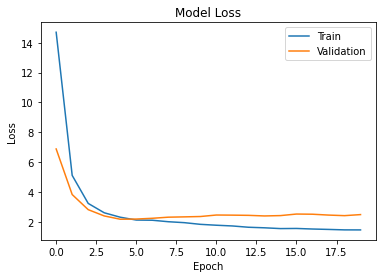

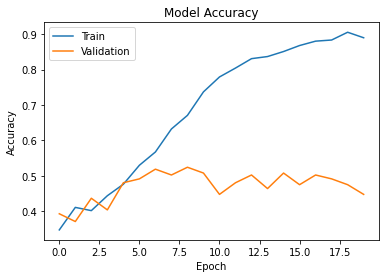

In [ ]:
hist_lr1 = History()
model = create_model(32, 64, 64, 32, 0.5, 0.001, 0.0001)
model.fit(X_shiftnoise, y_shiftnoise, epochs=20, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_lr1])
plothist(hist_lr1)

Epoch 1/20
23/23 [==============================] - 12s 413ms/step - loss: 23.0353 - accuracy: 0.4110 - val_loss: 13.3842 - val_accuracy: 0.3934
Epoch 2/20
23/23 [==============================] - 8s 337ms/step - loss: 10.4000 - accuracy: 0.4356 - val_loss: 8.0730 - val_accuracy: 0.2623
Epoch 3/20
23/23 [==============================] - 8s 343ms/step - loss: 6.8068 - accuracy: 0.4247 - val_loss: 5.6981 - val_accuracy: 0.3224
Epoch 4/20
23/23 [==============================] - 8s 343ms/step - loss: 4.9944 - accuracy: 0.3986 - val_loss: 4.2925 - val_accuracy: 0.3934
Epoch 5/20
23/23 [==============================] - 8s 340ms/step - loss: 3.8466 - accuracy: 0.4247 - val_loss: 3.4451 - val_accuracy: 0.3934
Epoch 6/20
23/23 [==============================] - 8s 339ms/step - loss: 3.1707 - accuracy: 0.4521 - val_loss: 2.9918 - val_accuracy: 0.4590
Epoch 7/20
23/23 [==============================] - 8s 337ms/step - loss: 2.8404 - accuracy: 0.4589 - val_loss: 2.6831 - val_accuracy: 0.4645
Ep

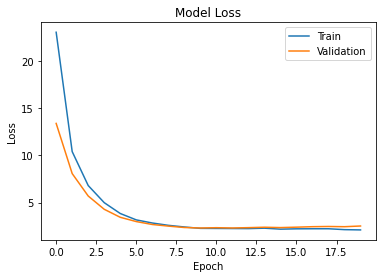

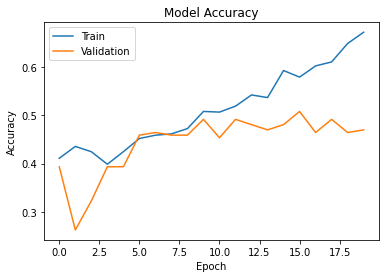

In [ ]:
hist_lr1 = History()
model = create_model(32, 64, 64, 32, 0.5, 0.001, 0.0001)
model.fit(X_train, y_bin, epochs=20, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist_lr1])
plothist(hist_lr1)